In [1]:
import os, time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_netpyne.config import *

# For a minimal example, select:
N_REGIONS = None # total TVB brain regions
NETPYNE_NODES_INDS = np.array([0, 1])  # the brain region nodes to place spiking networks from [0, N_REGIONS-1] interval
N_NEURONS = 100 # number of neurons per spiking population

# Interface basic configurations:
INTERFACE_MODEL = "RATE"  # The only available option for NetPyNE so far
INTERFACE_COUPLING_MODE = "spikeNet"  # "spikeNet" # "TVB"
# -----------------------------------------------

work_path = os.getcwd()
outputs_path = os.path.join(work_path, "outputs/NetPyNE_RedWongWang_%s_%s" % (INTERFACE_MODEL, INTERFACE_COUPLING_MODE))

config = Config(output_base=outputs_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 


## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

CoSimulatorSerialBuilder (
  title .................................. 'CoSimulatorSerialBuilder gid: 37444bbf-95bb-4d74-9a4a-9129a80dee94'
  Type ................................... 'CoSimulatorSerialBuilder'
  config ................................. '--------------------'
  config.title ........................... 'Config gid: d8dec2fa-6ea1-4a48-a647-07c658266fd6'
  config.Type ............................ 'Config'
  config.gid ............................. UUID('d8dec2fa-6ea1-4a48-a647-07c658266fd6')
  logger ................................. <Logger tvb-multiscale (DEBUG)>
  model .................................. ReducedWongWangExcIOInhI gid: 35403eba-3f04-4331-bdcb-3d910d342090
  model_params[G] ........................ --------------------
  model_params[G]: shape ................. (1,)
  model_params[G]: dtype ................. float64
  model_params[G]: values ................ 2
  model_params[lamda] .................... --------------------
  model_params[lamda]: shape .....

(<Figure size 1440x1080 with 2 Axes>,
 <AxesSubplot:title={'center':'Connectivity'}>,
 <Figure size 1440x1080 with 2 Axes>,
 <AxesSubplot:title={'center':"Tracts' lengths"}>)

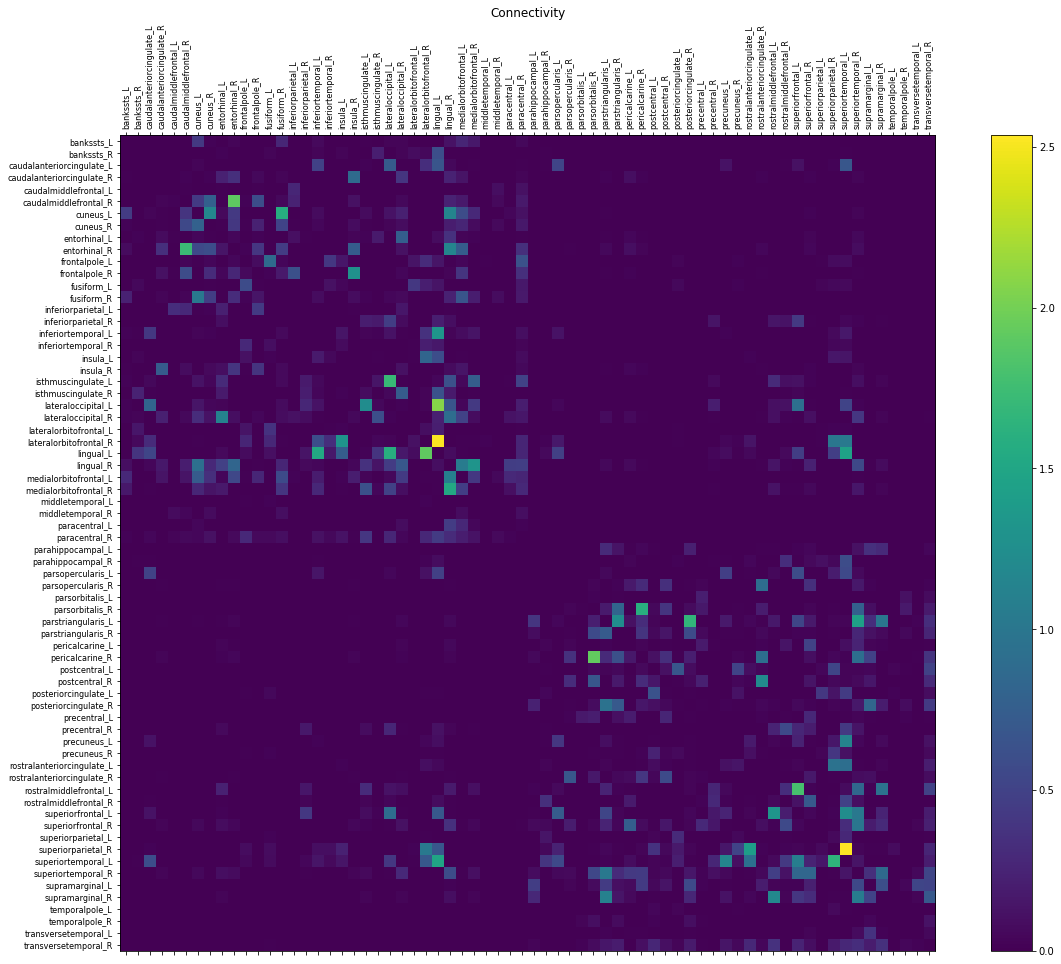

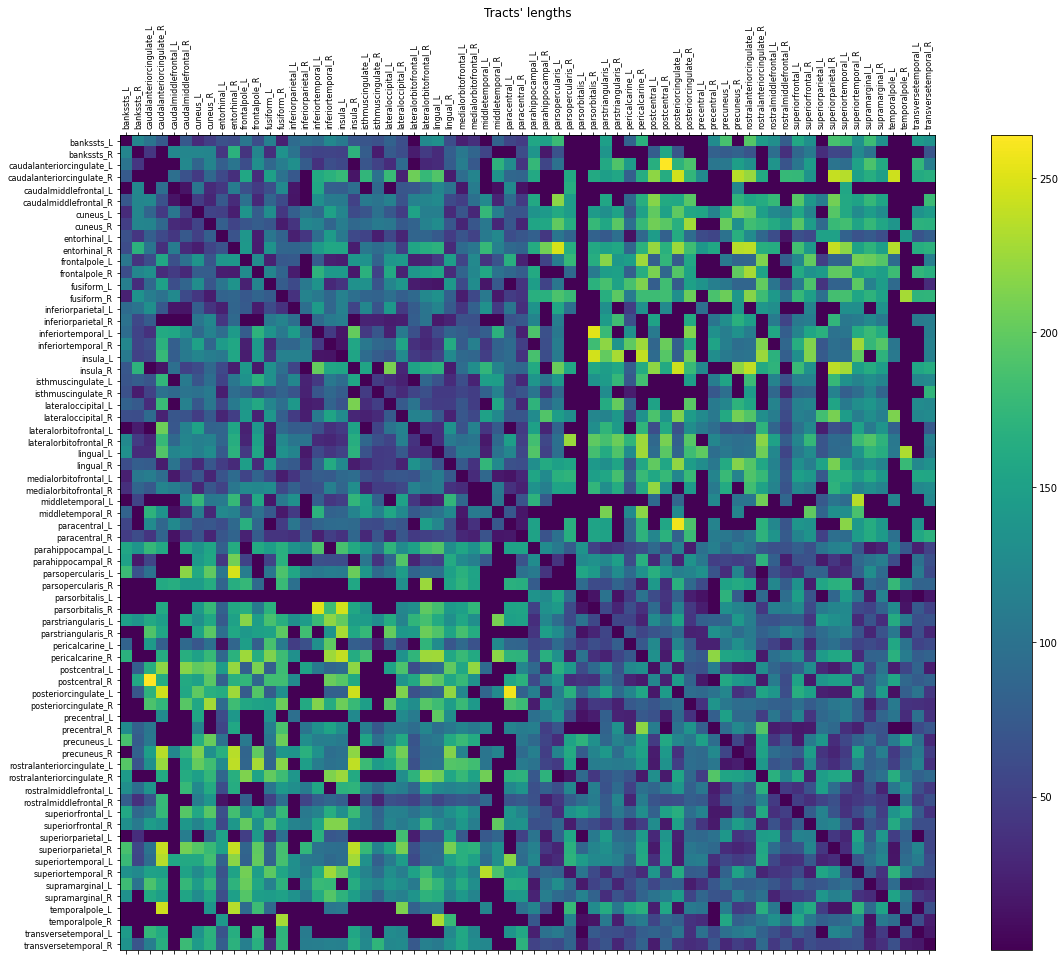

In [2]:
# This would run on TVB only before creating any multiscale cosimulation interface connections.

from tvb_multiscale.core.tvb.cosimulator.models.reduced_wong_wang_exc_io_inh_i import ReducedWongWangExcIOInhI

# Reduced Wong-Wang model params

model_params = {
    "G": np.array([2.0]),       # Global cloupling scaling
    "lamda": np.array([0.0]),   # Feedforward inhibition
    "w_p": np.array([1.4]),     # Feedback excitation
    "J_i": np.array([1.0]),     # Feedback inhibition
}

# Load and adjust connectivity
from tvb.datatypes.connectivity import Connectivity

# config.DEFAULT_CONNECTIVITY_ZIP = "/home/docker/packages/tvb_data/tvb_data/mouse/allen_2mm/ConnectivityAllen2mm.zip"                                  
connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)

connectivity.configure()

# -------------- Pick a minimal brain of only the first N_REGIONS regions: ----------------
if N_REGIONS is not None:
    connectivity.number_of_regions = N_REGIONS
    connectivity.region_labels = connectivity.region_labels[:N_REGIONS]
    connectivity.centres = connectivity.centres[:N_REGIONS]
    connectivity.areas = connectivity.areas[:N_REGIONS]
    connectivity.orientations = connectivity.orientations[:N_REGIONS]
    connectivity.hemispheres = connectivity.hemispheres[:N_REGIONS]
    connectivity.cortical = connectivity.cortical[:N_REGIONS]
    connectivity.weights = connectivity.weights[:N_REGIONS][:, :N_REGIONS]
    connectivity.tract_lengths = connectivity.tract_lengths[:N_REGIONS][:, :N_REGIONS]
# -----------------------------------------------------------------------------------------

# Remove diagonal self-connections:
np.fill_diagonal(connectivity.weights, 0.0)
    
# Normalize connectivity weights
connectivity.weights /= np.percentile(connectivity.weights, 99)

# # -----------------------------------Build cosimunlator manually--------------------------------
# from tvb_multiscale.core.tvb.cosimulator.cosimulator_serial import CoSimulatorSerial
# from tvb.simulator.coupling import Linear
# from tvb.simulator.integrators import HeunStochastic
# from tvb.simulator.monitors import Raw  # , Bold, EEG

# simulator = CoSimulatorSerial()

# simulator.model = ReducedWongWangExcIOInhI(**model_params)

# simulator.connectivity = connectivity

# simulator.coupling = Linear()

# simulator.integrator = HeunStochastic()
# simulator.integrator.dt = 0.1
# simulator.integrator.noise.nsig = np.array([config.DEFAULT_NSIG, config.DEFAULT_NSIG]) # 0.001

# simulator.initial_conditions = np.zeros((1, 2, simulator.connectivity.number_of_regions, 1))

# mon_raw = Raw(period=1.0)  # ms
# simulator.monitors = (mon_raw, )

# -----------------------------------Or use the CoSimulator builder--------------------------------
from tvb_multiscale.core.tvb.cosimulator.cosimulator_builder import CoSimulatorSerialBuilder

simulator_builder = CoSimulatorSerialBuilder()
simulator_builder.config = config
simulator_builder.model = ReducedWongWangExcIOInhI()
simulator_builder.connectivity = connectivity
simulator_builder.model_params = model_params
simulator_builder.initial_conditions = np.zeros((1, 1, 1, 1))

simulator_builder.configure()
simulator_builder.print_summary_info_details(recursive=1)

simulator = simulator_builder.build()
# -----

simulator.configure()


simulator.print_summary_info_details(recursive=1)

# Plot TVB connectome:
plotter.plot_tvb_connectivity(simulator.connectivity)

## 2. Build and connect the NetPyNE network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [3]:
# Build a NetPyNE network model with the corresponding builder
from tvb_multiscale.tvb_netpyne.netpyne_models.builders.netpyne_factory import load_netpyne

# from tvb_multiscale.core.utils.file_utils import load_pickled_dict
# sim_serial = load_pickled_dict(sim_serial_filepath)

# Load NetPyNE
netpyne = load_netpyne(config=config)


# ------ Instantiating a non-opinionated NetPyNE network builder for this model, ----------------- 
# ... and setting desired network description:


from tvb_multiscale.tvb_netpyne.netpyne_models.builders.base import NetpyneNetworkBuilder

netpyne_model_builder = NetpyneNetworkBuilder(simulator, spiking_nodes_inds=NETPYNE_NODES_INDS, netpyne_instance=netpyne, config=config)

netpyne_model_builder.population_order = N_NEURONS
netpyne_model_builder.tvb_to_spiking_dt_ratio = 2 # 2 NetPyNE integration steps for 1 TVB integration step
netpyne_model_builder.monitor_period = 1.0

scale_e = 1.2
scale_i = 0.6

# Set populations:
netpyne_model_builder.populations = [
    {
        "label": "E", # Population label, inherent to TVB mean-field model
        "model": "PYR", # NetPyNE cell model
        "nodes": None,  # None means "all" -> building this population to all spiking_nodes_inds
        "params": {}, # custom parameters can go here
        "scale": scale_e # multiply netpyne_model_builder.population_order for the exact populations' size
    },
    {
        "label": "I",
        "model": "PYR",
        "nodes": None,
        "scale": scale_i
    }
]

# Set populations' connections within brain region nodes
weight_ee = 0.015
weight_ei = 0.01
weight_ie = 0.01
weight_ii = 0.01

receptor_type_E = 'exc'
receptor_type_I = 'inh'

conn_spec_all_to_all = {"rule": "all_to_all"}
conn_spec_prob_low = {"rule": {"prob": 0.01}}
conn_spec_prob_high = {"rule": {"prob": 0.03}}

netpyne_model_builder.populations_connections = [
    {
        "source": "E", "target": "E",  # E -> E This is a self-connection for population "E"
        # ---------------- Possibly functions of spiking_nodes_inds -------------------------- 
        "conn_spec": conn_spec_prob_low,
        "weight": weight_ee, # NetPyNE connection weight
        "delay": 1,
        "receptor_type": receptor_type_E,
        # ---------------- Possibly functions of spiking_nodes_inds --------------------------
        "nodes": None}, # None means "all" -> performing this connection to all spiking_nodes_inds
    {
        "source": "E", "target": "I",  # E -> I
        "conn_spec": conn_spec_prob_low, 
        "weight": weight_ei,
        "delay": 3,
        "receptor_type": receptor_type_E, 
        "nodes": None},
    {
        "source": "I", "target": "E",  # I -> E
        "conn_spec": conn_spec_prob_high, 
        "weight": weight_ie,
        "delay": 3,
        "receptor_type": receptor_type_I, 
        "nodes": None},
    {
        "source": "I", "target": "I",  # I -> I
        "conn_spec": conn_spec_prob_low, 
        "weight": weight_ii,
        "delay": 1,
        "receptor_type": receptor_type_I,
        "nodes": None}
]


def tvb_weight_fun(source_node, target_node, lamda=None):
    weight = simulator.connectivity.weights[target_node, source_node]
    scale = netpyne_model_builder.global_coupling_scaling * netpyne_model_builder.netpyne_synaptic_weight_scale
    if lamda:
        scale *= lamda
    return weight * scale

def tvb_delay_fun(source_node, target_node):
    return simulator.connectivity.delays[target_node, source_node]

# lamda is the scale of E -> I connections between nodes
lamda = simulator.model.lamda[0]

netpyne_model_builder.nodes_connections = [
    {
        "source": "E", "target": "E",
        "conn_spec": conn_spec_prob_low,
        "weight": tvb_weight_fun,
        "delay": tvb_delay_fun,
        "receptor_type": receptor_type_E,
        "source_nodes": None, "target_nodes": None}  # None means "all"
    ]
if lamda > 0:
    netpyne_model_builder.nodes_connections.append({
        "source": "E", "target": "I",
        "conn_spec": conn_spec_prob_low,
        # using lamda to scale connectivity weights (or alternatively, it can be used to downscale connection probability in 'conn_spec' above):
        "weight": lambda source_node, target_node: tvb_weight_fun(source_node, target_node, lamda),
        "delay": tvb_delay_fun,
        "receptor_type": receptor_type_E,
        "source_nodes": None, "target_nodes": None})

# Set output recorder devices:
from collections import OrderedDict
connections = OrderedDict()
connections["E"] = "E" # label <- target population
connections["I"] = "I"
params = config.NETPYNE_OUTPUT_DEVICES_PARAMS_DEF["spike_recorder"].copy()
# params["record_to"] = self.output_devices_record_to
spike_recorder = {
    "model": "spike_recorder",
    "params": params,
    "connections": connections,
    "nodes": None}  # None means all here
netpyne_model_builder.output_devices = [spike_recorder]

from netpyne import specs
netParams = specs.NetParams()

netParams.synMechParams[receptor_type_E] = {'mod': 'Exp2Syn', 'tau1': 0.15, 'tau2': 1.5, 'e': 0}  # NMDA
netParams.synMechParams[receptor_type_I] = {'mod': 'Exp2Syn', 'tau1': 0.07, 'tau2': 9.1, 'e': -80}  # GABA

PYRcell = {'secs': {}}
PYRcell['secs']['soma'] = {'geom': {}, 'mechs': {}}  # soma params dict
PYRcell['secs']['soma']['geom'] = {'diam': 18.8, 'L': 18.8, 'Ra': 123.0}  # soma geometry
PYRcell['secs']['soma']['mechs']['hh'] = {'gnabar': 0.12, 'gkbar': 0.036, 'gl': 0.003, 'el': -70}  # soma hh mechanism
netParams.cellParams['PYR'] = PYRcell

cfg = specs.SimConfig()
cfg.recordTraces = {'V_soma': {'sec':'soma', 'loc':0.5, 'var':'v'}}  # Dict with traces to record

cfg.recordStep = 0.1
cfg.savePickle = False        # Save params, network and sim output to pickle file
cfg.saveJson = False


# Set the simulation time:
simulator.simulation_length = 220.0

# This will be transferred to NetPyNE
config.simulation_length = simulator.simulation_length

netpyne_model_builder.configure(netParams, cfg, autoCreateSpikingNodes=True)

def synaptic_weight_scale_func(is_coupling_mode_tvb):
    if is_coupling_mode_tvb: # "TVB"
        return 1e-2
    else: # "spikeNet"
        return 1

netpyne_model_builder.global_coupling_scaling *= simulator.model.G
netpyne_model_builder.netpyne_synaptic_weight_scale = synaptic_weight_scale_func(is_coupling_mode_tvb=INTERFACE_COUPLING_MODE=="TVB")

netpyne_network = netpyne_model_builder.build()

# Configure NetpyneNetwork class:
netpyne_network.configure()
netpyne_network.print_summary_info_details(recursive=3, connectivity=True)

--No graphics will be displayed.


2022-11-04 07:27:49,847 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring spiking network builder...
2022-11-04 07:27:49,847 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring spiking network builder...
2022-11-04 07:27:49,853 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring populations...
2022-11-04 07:27:49,853 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring populations...
2022-11-04 07:27:49,858 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring populations' connections within spiking region nodes...
2022-11-04 07:27:49,858 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring populations' connections within spiking region nodes...
2022-11-04 07:27:49,871 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring populations' connections among spiking region nodes...
2022-11-04 07:27:49,871 - INFO - tvb_multiscale.core.spiking_models.builders.

## 3. Build the TVB-NetPyNE interface

In [4]:
# Build a TVB-NetPyNE interface with all the appropriate connections between the
# TVB and NetPyNE modelled regions

from tvb_multiscale.tvb_netpyne.interfaces.builders import TVBNetpyneInterfaceBuilder   
tvb_netpyne_interface_builder = TVBNetpyneInterfaceBuilder()  # non opinionated builder

tvb_netpyne_interface_builder.config = config
tvb_netpyne_interface_builder.tvb_cosimulator = simulator            
tvb_netpyne_interface_builder.spiking_network = netpyne_network
# This can be used to set default tranformer and proxy models:
tvb_netpyne_interface_builder.model = INTERFACE_MODEL  # "RATE"
tvb_netpyne_interface_builder.input_flag = True   # If True, NetPyNE->TVB update will be implemented
tvb_netpyne_interface_builder.output_flag = True  # If True, TVB->NetPyNE coupling will be implemented
# If default_coupling_mode = "TVB", large scale coupling towards spiking regions is computed in TVB
# and then applied with no time delay via a single "TVB proxy node" / NetPyNE device for each spiking region,
# "1-to-1" TVB->NetPyNE coupling.
# If any other value, we need 1 "TVB proxy node" / NetPyNE device for each TVB sender region node, and
# large-scale coupling for spiking regions is computed in NetPyNE, 
# taking into consideration the TVB connectome weights and delays, 
# in this "1-to-many" TVB->NetPyNE coupling.
tvb_netpyne_interface_builder.default_coupling_mode = INTERFACE_COUPLING_MODE  # "spikeNet" # "TVB" 

# Number of neurons per population to be used to compute population mean instantaneous firing rates:
tvb_netpyne_interface_builder.N_E = int(netpyne_model_builder.population_order * scale_e)
tvb_netpyne_interface_builder.N_I = int(netpyne_model_builder.population_order * scale_i)

tvb_netpyne_interface_builder.proxy_inds = NETPYNE_NODES_INDS
# Set exclusive_nodes = True (Default) if the spiking regions substitute for the TVB ones:
tvb_netpyne_interface_builder.exclusive_nodes = True 

tvb_netpyne_interface_builder.synaptic_weight_scale_func = synaptic_weight_scale_func

tvb_netpyne_interface_builder.output_interfaces = []
tvb_netpyne_interface_builder.input_interfaces = []

# # Using all default parameters for this example of an opinionated builder
# tvb_netpyne_interface_builder.default_config()

# or setting a nonopinionated builder:
from tvb_multiscale.core.interfaces.tvb.interfaces import TVBtoSpikeNetModels

if tvb_netpyne_interface_builder.default_coupling_mode == "TVB":
    proxy_inds = NETPYNE_NODES_INDS
else:
    proxy_inds = np.arange(simulator.connectivity.number_of_regions).astype('i')
    proxy_inds = np.delete(proxy_inds, NETPYNE_NODES_INDS)


# This is a user defined TVB -> Spiking Network interface configuration:
tvb_netpyne_interface_builder.output_interfaces = [{
    'voi': np.array(["R_e"]),         # TVB state variable to get data from
    'populations': np.array(["E"]), # NetPyNE populations to couple to
    # --------------- Arguments that can default if not given by the user:------------------------------
    'model': tvb_netpyne_interface_builder.model, # This can be used to set default tranformer and proxy models
    'transformer_params': {'scale_factor': np.array([1.0])}, # due to the way Netpyne generates spikes, no scaling by population size is needed
    'proxy_params': {'number_of_neurons': tvb_netpyne_interface_builder.N_E},
    'receptor_type': receptor_type_E,
}]

if lamda > 0:
    tvb_netpyne_interface_builder.output_interfaces.append({
        'voi': np.array(["R_e"]),
        'populations': np.array(["I"]),
        # --------------- Arguments that can default if not given by the user:------------------------------
        'model': tvb_netpyne_interface_builder.model, # This can be used to set default tranformer and proxy models
        # due to the way Netpyne generates spikes, no scaling by population size is needed
        'transformer_params': {'scale_factor': np.array([1.0])},
        'proxy_params': {
            'number_of_neurons': tvb_netpyne_interface_builder.N_I,
            'lamda': lamda
        },
        'receptor_type': receptor_type_E,
    })

# These are user defined Spiking Network -> TVB interfaces configurations:
for sVars, pop in zip([("S_e", "R_e"), ("S_i", "R_i")], ["E", "I"]):
    tvb_netpyne_interface_builder.input_interfaces.append(
        {'voi': sVars,
        'populations': np.array([pop]),
        'proxy_inds': NETPYNE_NODES_INDS,
        # --------------- Arguments that can default if not given by the user:------------------------------
        # Set the enum entry or the corresponding label name for the "proxy_model", 
        # options "SPIKES" (i.e., spikes per neuron), "SPIKES_MEAN", "SPIKES_TOTAL" 
        # (the last two are identical for the moment returning all populations spikes together)
        'proxy_model': "SPIKES_MEAN",  
        # Set the enum entry or the corresponding label name for the "transformer_model", 
        # or import and set the appropriate tranformer class, e.g., ElephantSpikesHistogramRate, directly
        # options: "SPIKES", "SPIKES_TO_RATE", "SPIKES_TO_HIST", "SPIKES_TO_HIST_RATE"
        # see tvb_multiscale.core.interfaces.base.transformers.models.DefaultSpikeNetToTVBTransformers for options and related Transformer classes,
        # and tvb_multiscale.core.interfaces.base.transformers.models.DefaultSpikeNetToTVBModels for default choices
        'transformer_model': "SPIKES_TO_HIST_RATE",
        }
    )

for interface, N in zip(tvb_netpyne_interface_builder.input_interfaces, 
                        [tvb_netpyne_interface_builder.N_E, tvb_netpyne_interface_builder.N_I]):
    # The "scale_factor" scales the instantaneous rate coming from NetPyNE, before setting it to TVB,
    # in our case converting the rate to a mean reate 
    # and scaling it to be in the TVB model's state variable range [0.0, 1.0]
    interface["transformer_params"] = {"scale_factor": np.array([1.0]) / N}

# Configure and build:
tvb_netpyne_interface_builder.configure()
tvb_netpyne_interface_builder.print_summary_info_details(recursive=1)

# This is how the user defined TVB -> Spiking Network interface looks after configuration
print("\noutput (TVB->NetPyNE coupling) interfaces' configurations:\n")
display(tvb_netpyne_interface_builder.output_interfaces)

# This is how the user defined Spiking Network -> TVB interfaces look after configuration
print("\ninput (NetPyNE->TVB update) interfaces' configurations:\n")
display(tvb_netpyne_interface_builder.input_interfaces)

Failed to summarize: 
tvb_cosimulator.monitors
tuple
'NoneType' object has no attribute 'tolist'
TVBNetpyneInterfaceBuilder (
  title ............................................... 'TVBNetpyneInterfaceBuilder gid: ca974c28-9a67-475d-aca3-12cf6c797f0b'
  Type ................................................ 'TVBNetpyneInterfaceBuilder'
  spiking_network ..................................... '--------------------'
  spiking_network.title ............................... 'NetpyneNetwork gid: 5ea91e72-ed91-4cce-a437-a33542882e3d'
  spiking_network.Type ................................ 'NetpyneNetwork'
  spiking_network.config .............................. Config gid: d8dec2fa-6ea1-4a48-a647-07c658266fd6
  spiking_network.brain_regions ....................... NetpyneBrain gid: 7483413f-94a5-4cc5-9ea2-ff58f23a373c
  spiking_network.output_devices ...................... DeviceSets gid: e2e45384-04af-4f38-89c2-4b9df39702c4
  spiking_network.input_devices ....................... DeviceSets gid

[{'voi': array([2]),
  'populations': array(['E'], dtype='<U1'),
  'model': 'RATE',
  'proxy_params': {'number_of_neurons': 120},
  'receptor_type': 'exc',
  'coupling_mode': 'spikeNet',
  'proxy_inds': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
         53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
  'voi_labels': array(['R_e'], dtype='<U3'),
  'monitor_ind': 0,
  'proxy': tvb_multiscale.tvb_netpyne.interfaces.io.NetpynePoissonGeneratorSet,
  'transformer': <tvb_multiscale.core.interfaces.base.transformers.models.base.LinearRate at 0x7f43f8185790>}]


input (NetPyNE->TVB update) interfaces' configurations:



[{'voi': array([0, 2]),
  'populations': array(['E'], dtype='<U1'),
  'proxy_inds': array([0, 1]),
  'voi_labels': array(['S_e', 'R_e'], dtype='<U3'),
  'proxy': tvb_multiscale.tvb_netpyne.interfaces.io.NetpyneSpikeRecorderTotalSet,
  'transformer': <tvb_multiscale.core.interfaces.base.transformers.models.elephant.ElephantSpikesHistogramRate at 0x7f43ec313580>},
 {'voi': array([1, 3]),
  'populations': array(['I'], dtype='<U1'),
  'proxy_inds': array([0, 1]),
  'voi_labels': array(['S_i', 'R_i'], dtype='<U3'),
  'proxy': tvb_multiscale.tvb_netpyne.interfaces.io.NetpyneSpikeRecorderTotalSet,
  'transformer': <tvb_multiscale.core.interfaces.base.transformers.models.elephant.ElephantSpikesHistogramRate at 0x7f43ec313520>}]

## 4. Configure simulator, simulate, gather results

In [5]:
simulator = tvb_netpyne_interface_builder.build()

# NetPyNE model is built in two steps. First need to create declarative-style specification for both spiking network itself and TVB-Netpyne proxy devides (interfaces).
# Once it's done above using builders, network can be instantiated based on the specification:
netpyne_network.netpyne_instance.instantiateNetwork()


simulator.simulate_spiking_simulator = netpyne_network.netpyne_instance.run  # set the method to run NetPyNE

# simulator.print_summary_info(recursive=3)
# simulator.print_summary_info_details(recursive=3)

print("\n\noutput (TVB->NetPyNE coupling) interfaces:\n")
simulator.output_interfaces.print_summary_info_details(recursive=2)

print("\n\ninput (NetPyNE->TVB update) interfaces:\n")
simulator.input_interfaces.print_summary_info_details(recursive=2)

2022-11-04 07:27:52,683 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model poisson_generator for ['R_e']->['E'] created!
2022-11-04 07:27:52,683 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model poisson_generator for ['R_e']->['E'] created!
Netpyne:: will create internal device ['R_e']->['E'] - caudalanteriorcingulate_L. Model: poisson_generator, params: {'number_of_neurons': 120}
Netpyne:: Creating artif cells for node '['R_e']->['E'] - caudalanteriorcingulate_L' of 120 neurons
Netpyne:: will connect input device poisson_generator. ['R_e']->['E'] - caudalanteriorcingulate_L -> bankssts_L.E (weight: 3.998908423934632e-06, delay: 34.04999923706055)
Netpyne:: will connect input device poisson_generator. ['R_e']->['E'] - caudalanteriorcingulate_L -> bankssts_R.E (weight: 2.912312174950049e-05, delay: 14.050000190734863)
Netpyne:: will creat

In [17]:
# Configure the simulator with the TVB-NetPyNE interface...
# ...and simulate!

tic = time.time()

print("Simulating TVB-NetPyNE...")
simulator.configure()

# Adjust simulation length to be an integer multiple of synchronization_time:
if simulator.synchronization_time == 0:
    simulator.synchronization_time = 3.6
simulator.simulation_length = \
            np.ceil(simulator.simulation_length / simulator.synchronization_time) * simulator.synchronization_time

results = simulator.run()

# netpyne_network.netpyne_instance.finalize()

print("\nSimulated in %f secs!" % (time.time() - tic))

Simulating TVB-NetPyNE...
2022-11-04 07:32:06,556 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Region simulation with 68 ROI nodes
2022-11-04 07:32:06,569 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Memory requirement estimate: simulation will need about 4.4 MB
2022-11-04 07:32:06,583 - ERROR - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
2022-11-04 07:32:06,587 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Using provided initial history of shape (1, 4, 68, 1)
2022-11-04 07:32:06,693 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Final initial history shape is (880, 4, 68, 1)
2022-11-04 07:32:06,702 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - initial state has shape (4, 68, 1)
2022-11-04 07:32:06,714 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Memory requirement census: simulation will need about 3

## 5. Plot results and write them to HDF5 files

In [7]:
from scipy.io import savemat
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9

# Set the transient time to be optionally removed from results:
simulation_length = simulator.simulation_length
transient = 0.1 * simulation_length 

## TVB plots

In [8]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.tvb.io.h5_writer import H5Writer
    from examples.plot_write_results import write_RegionTimeSeriesXarray_to_h5
    writer = H5Writer()
    
except:
    writer = False
    
# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

source_ts = None
t = simulation_length * simulator.integrator.dt
if results is not None:
    # Substitute with TimeSeriesRegion fot TVB like functionality:
    # from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
    source_ts = TimeSeriesXarray(  
            data=results[0][1], time=results[0][0],
            connectivity=simulator.connectivity,
            labels_ordering=["Time", "State Variable", "Region", "Neurons"],
            labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                               "Region": simulator.connectivity.region_labels.tolist()},
            sample_period=simulator.integrator.dt)
    source_ts.configure()

    t = source_ts.time

    # Write to file
    if writer:
        write_RegionTimeSeriesXarray_to_h5(source_ts, writer,
                                           os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
    source_ts

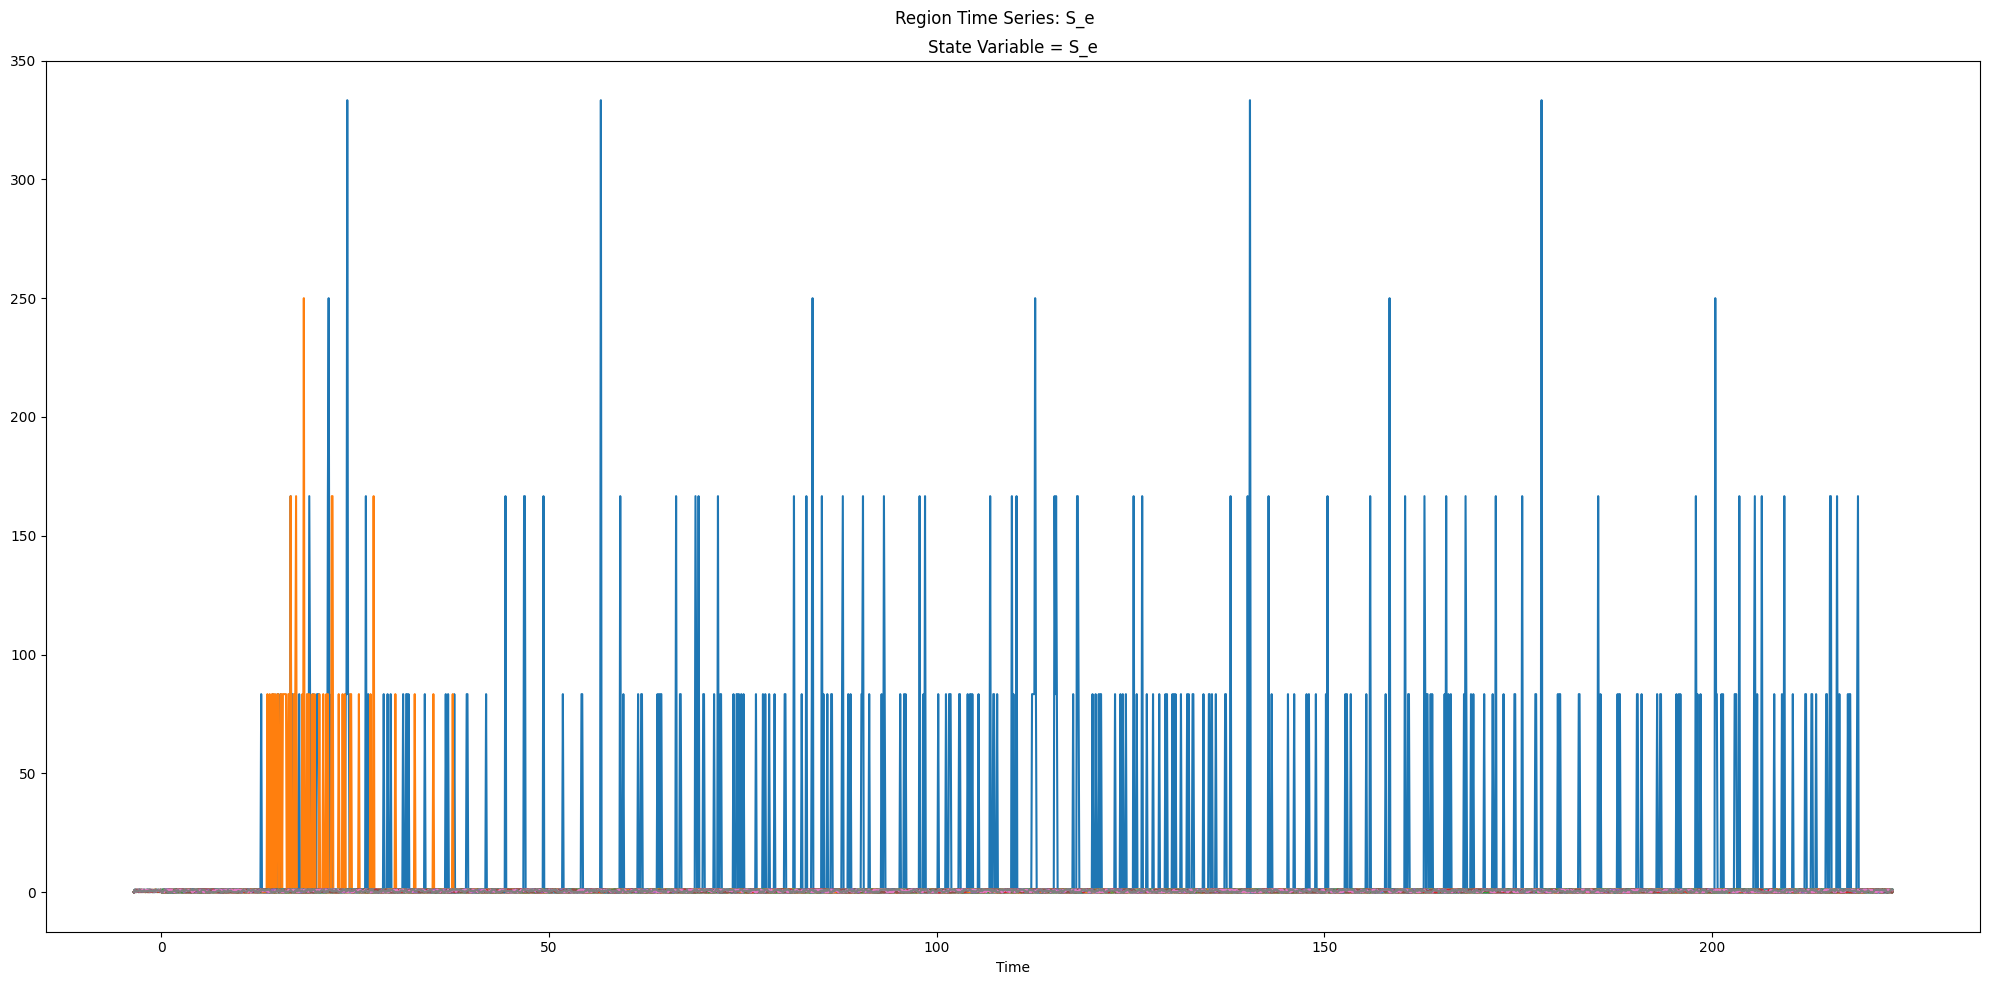

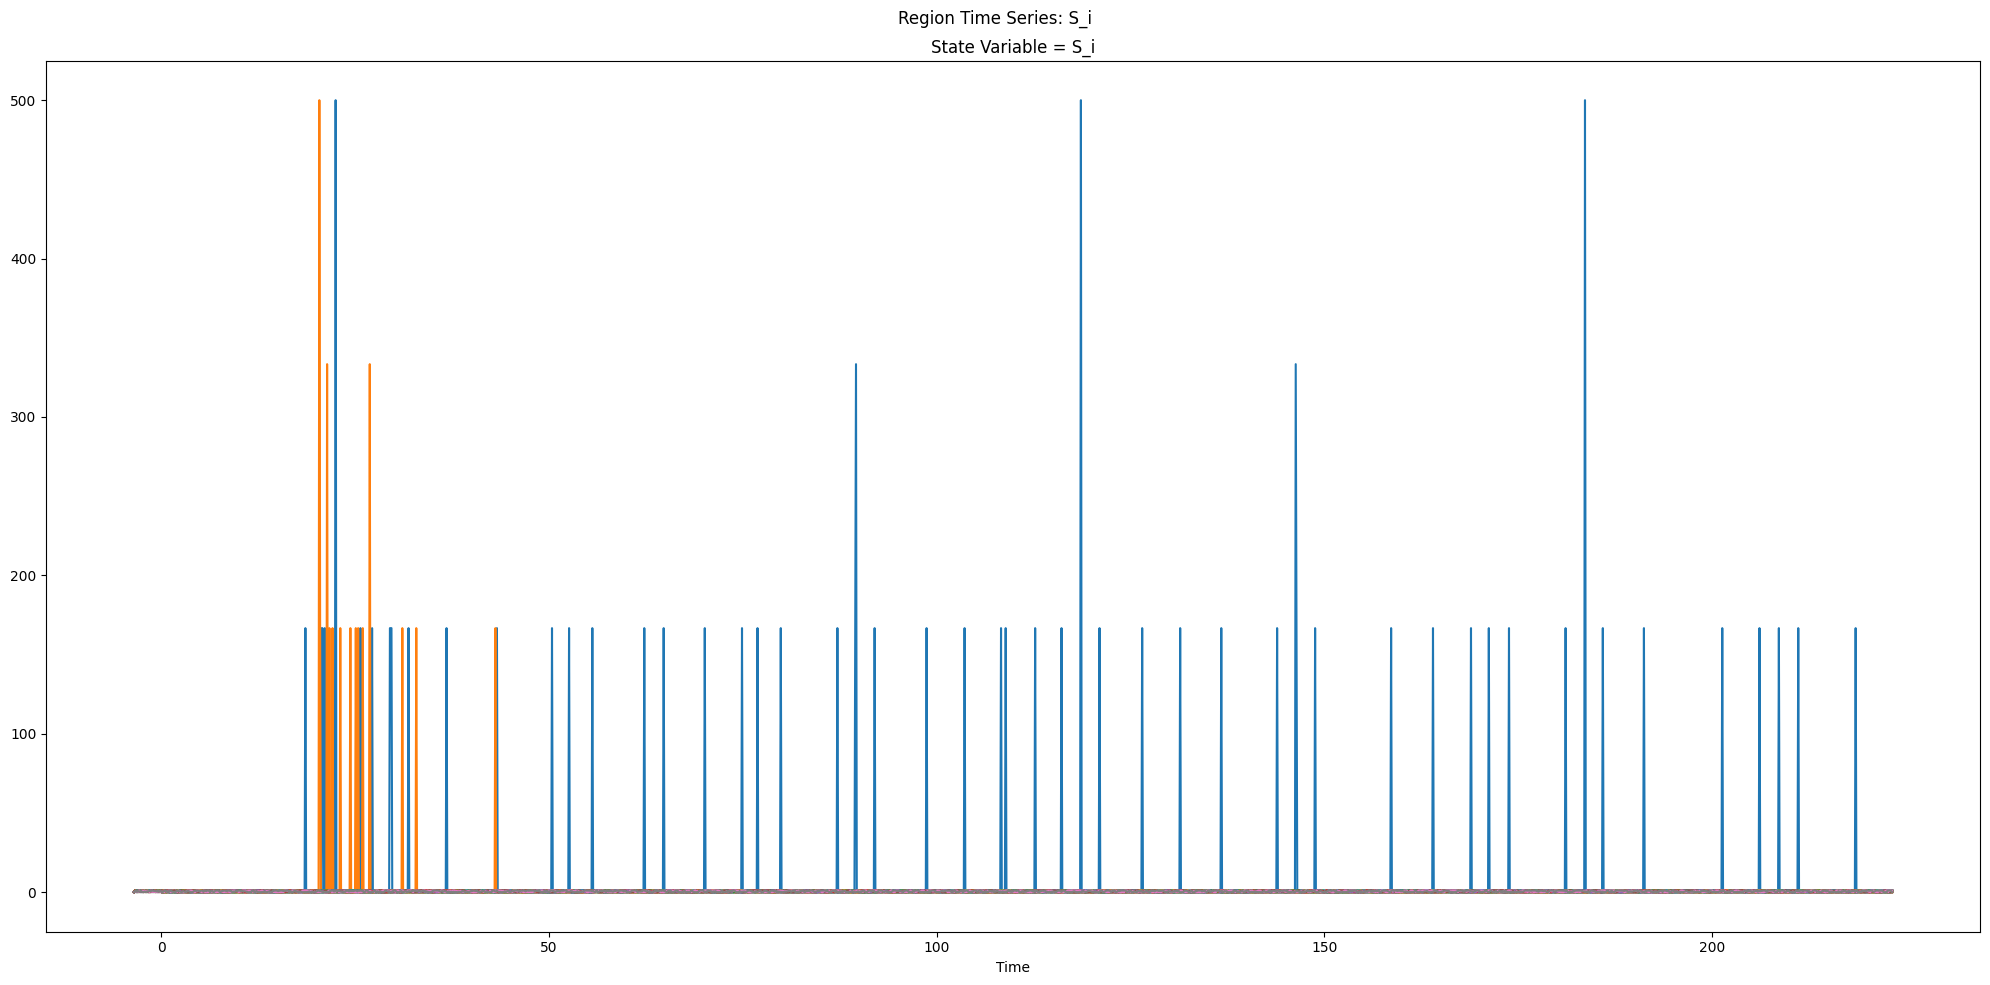

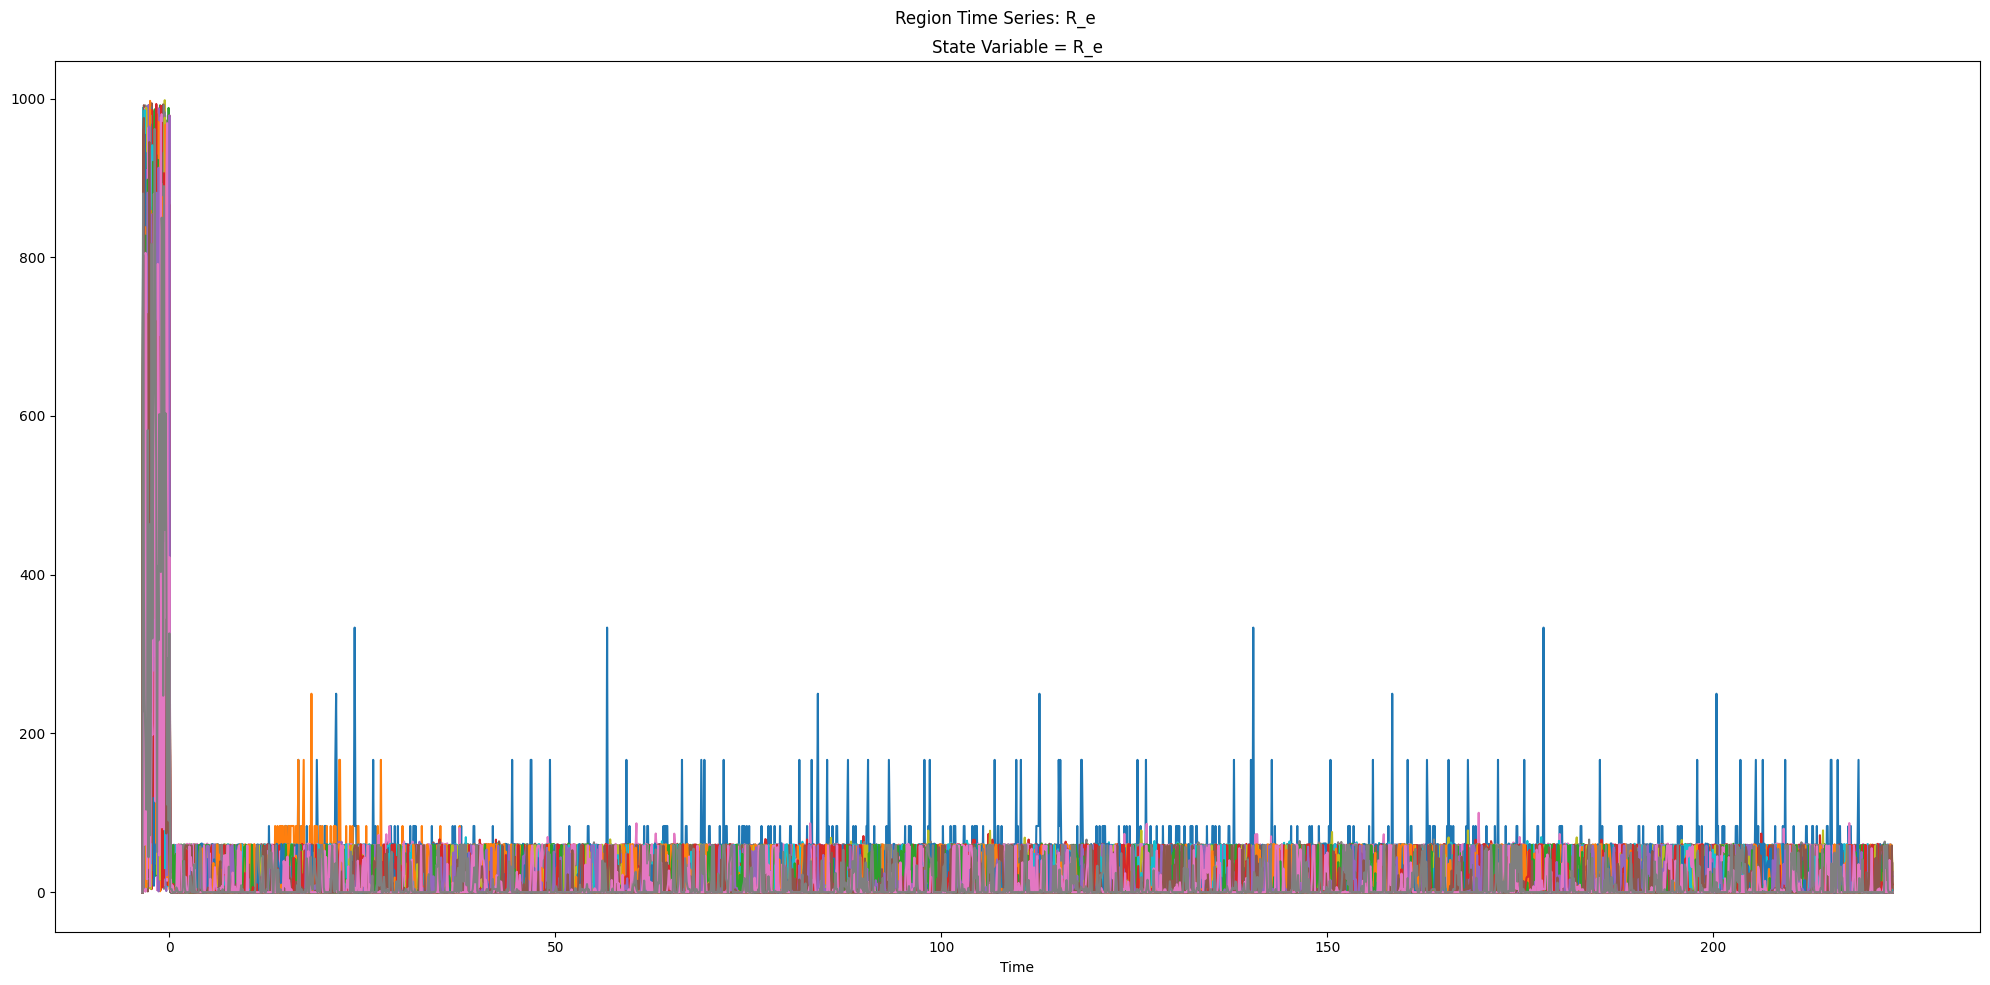

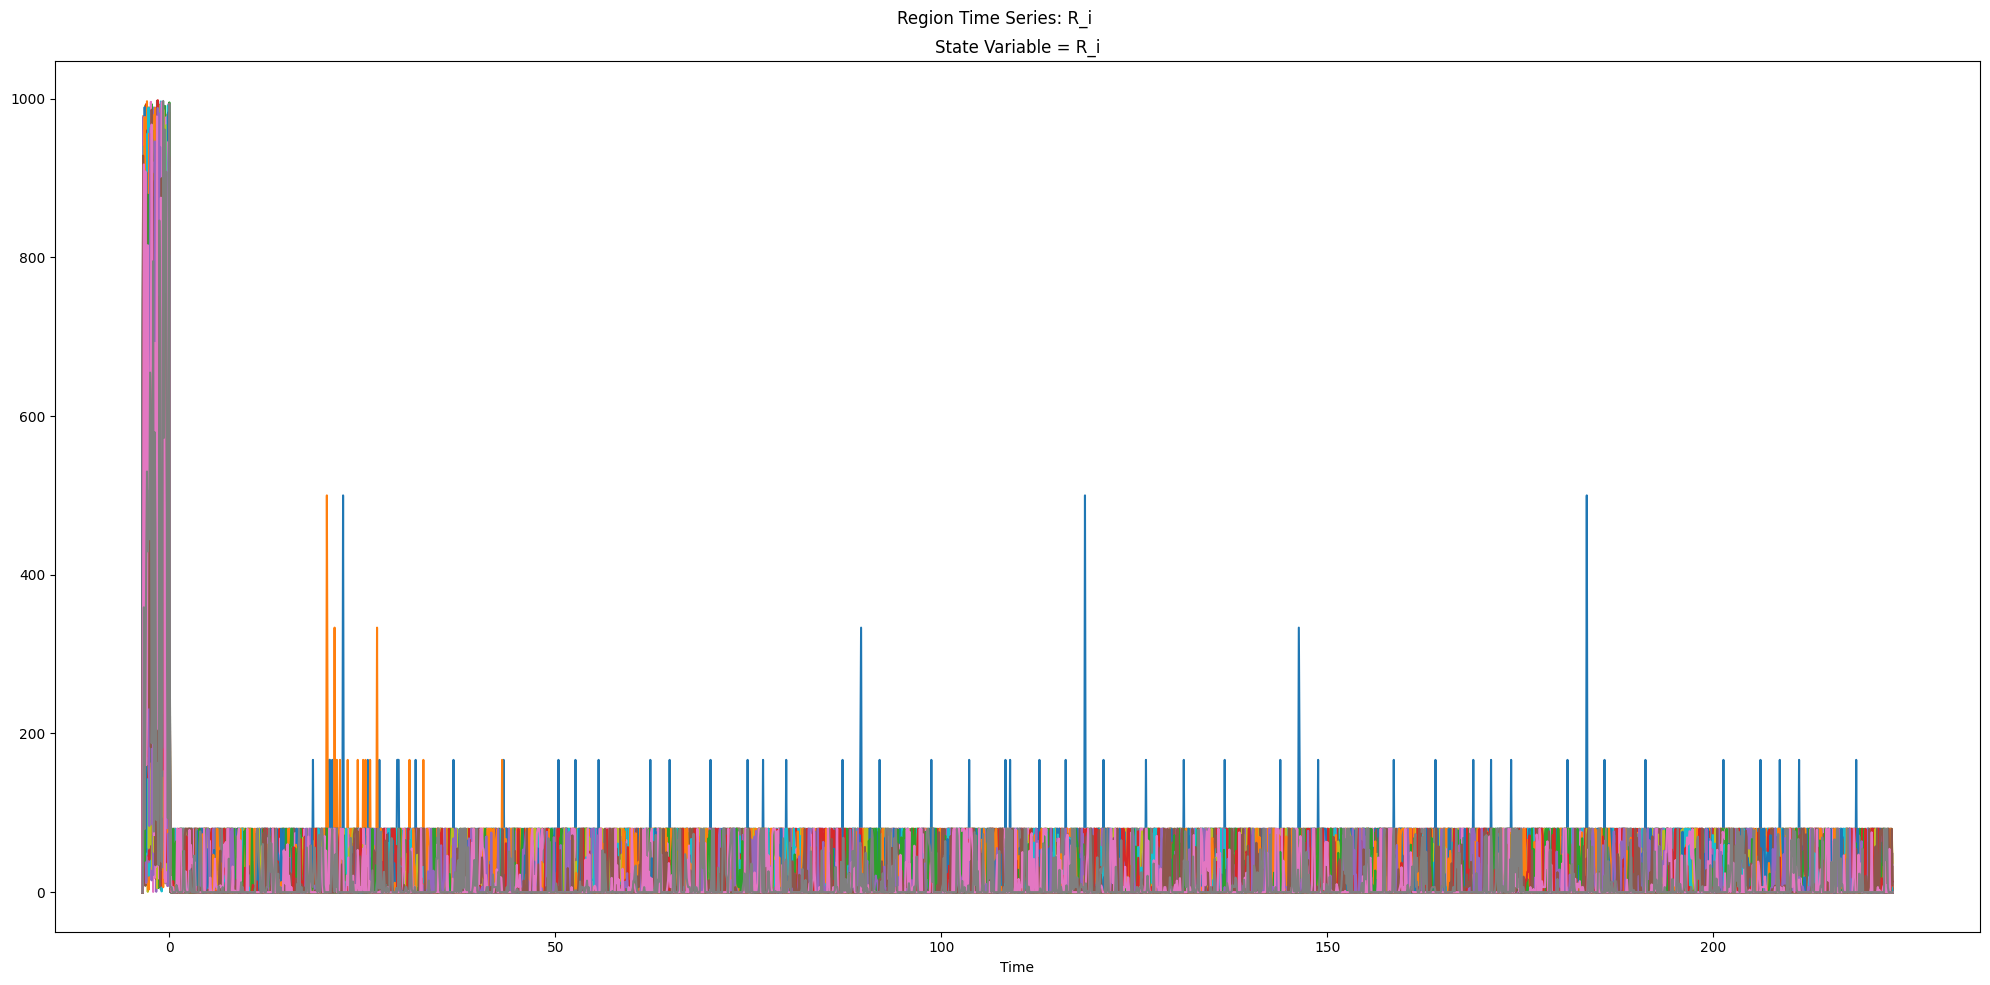

In [9]:
# Plot TVB time series
if source_ts is not None:
    source_ts.plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

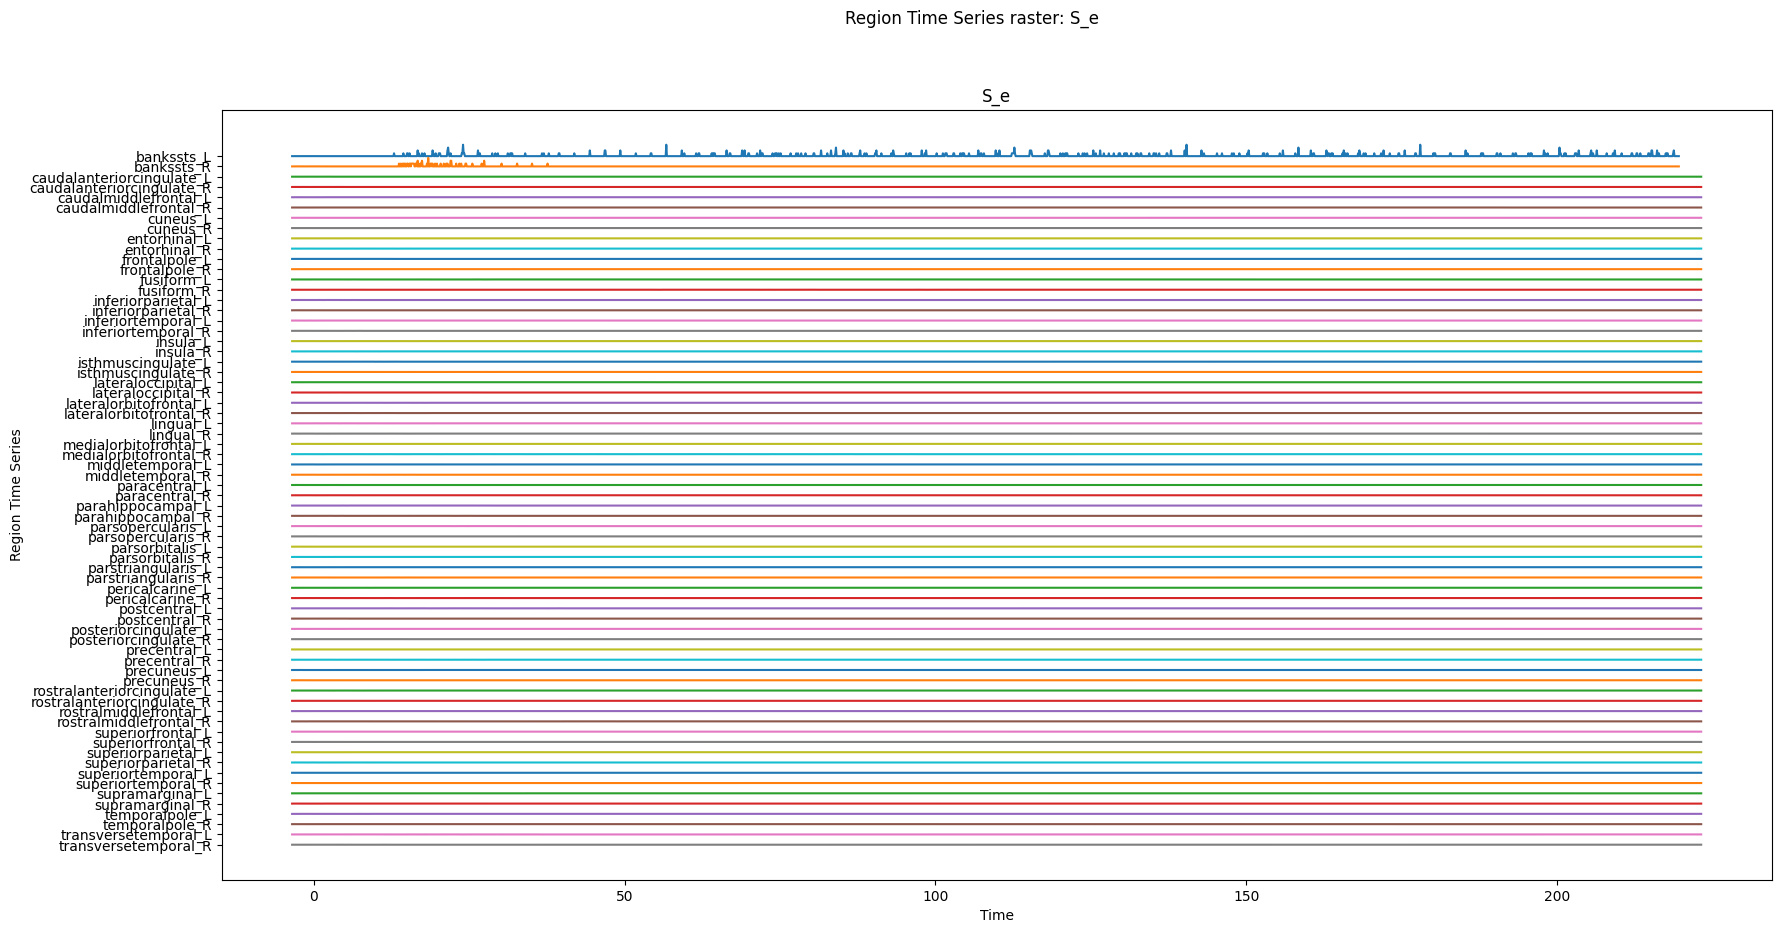

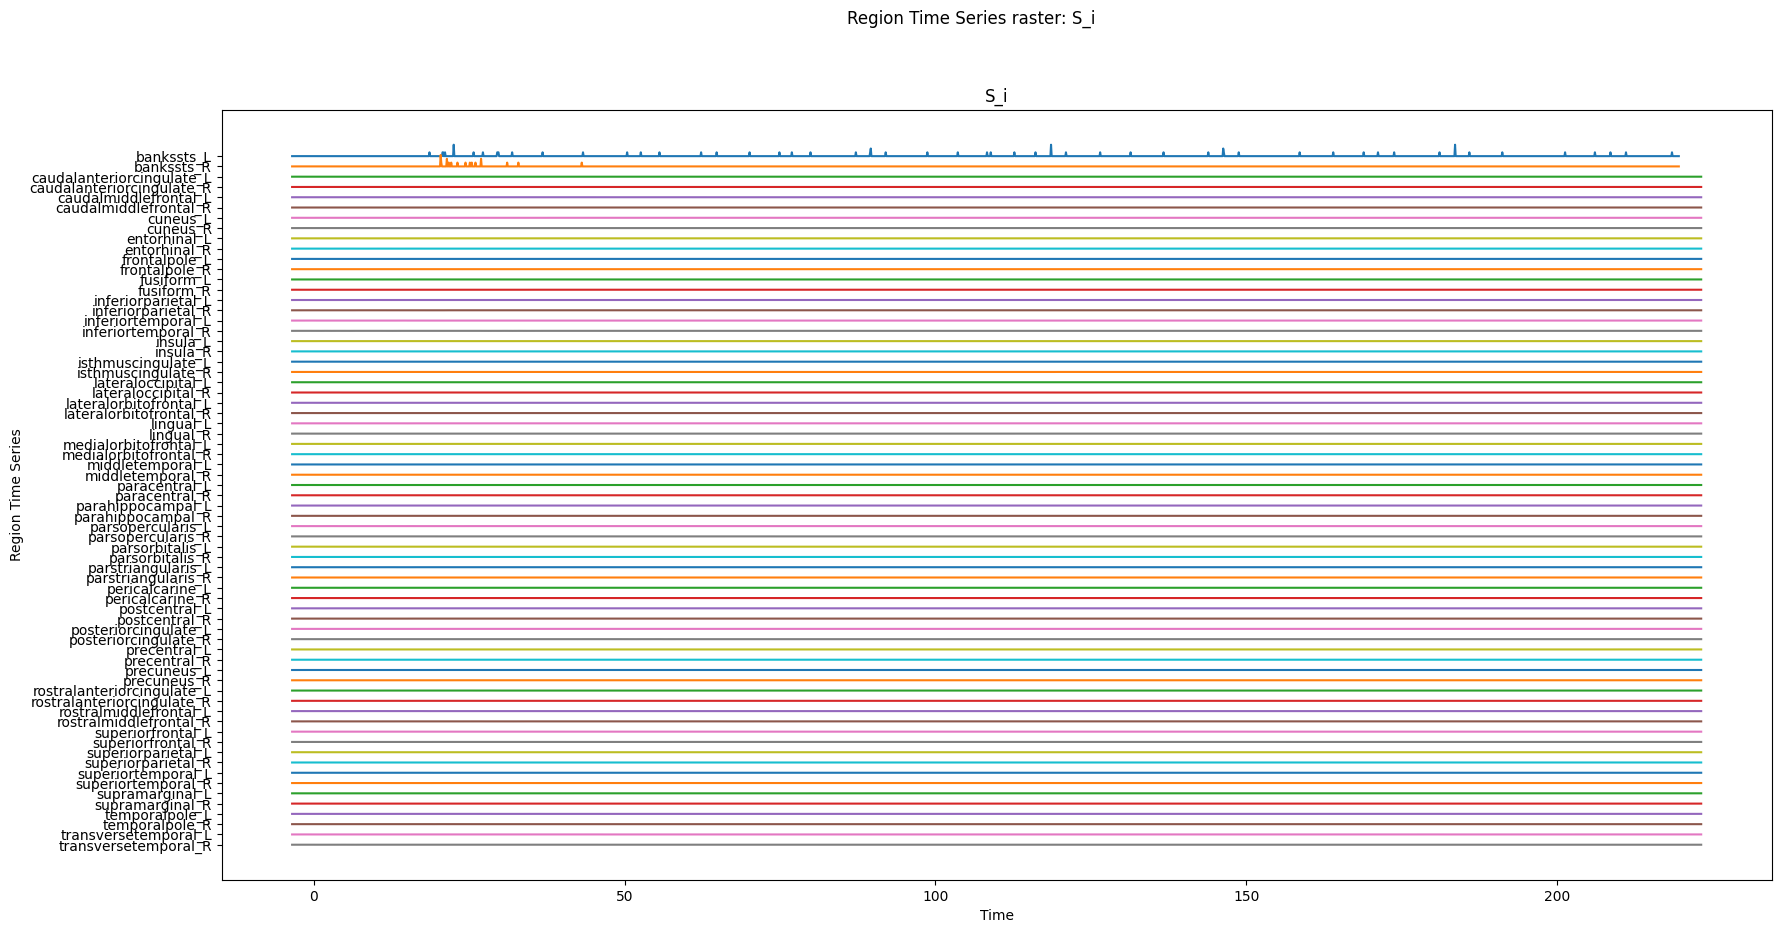

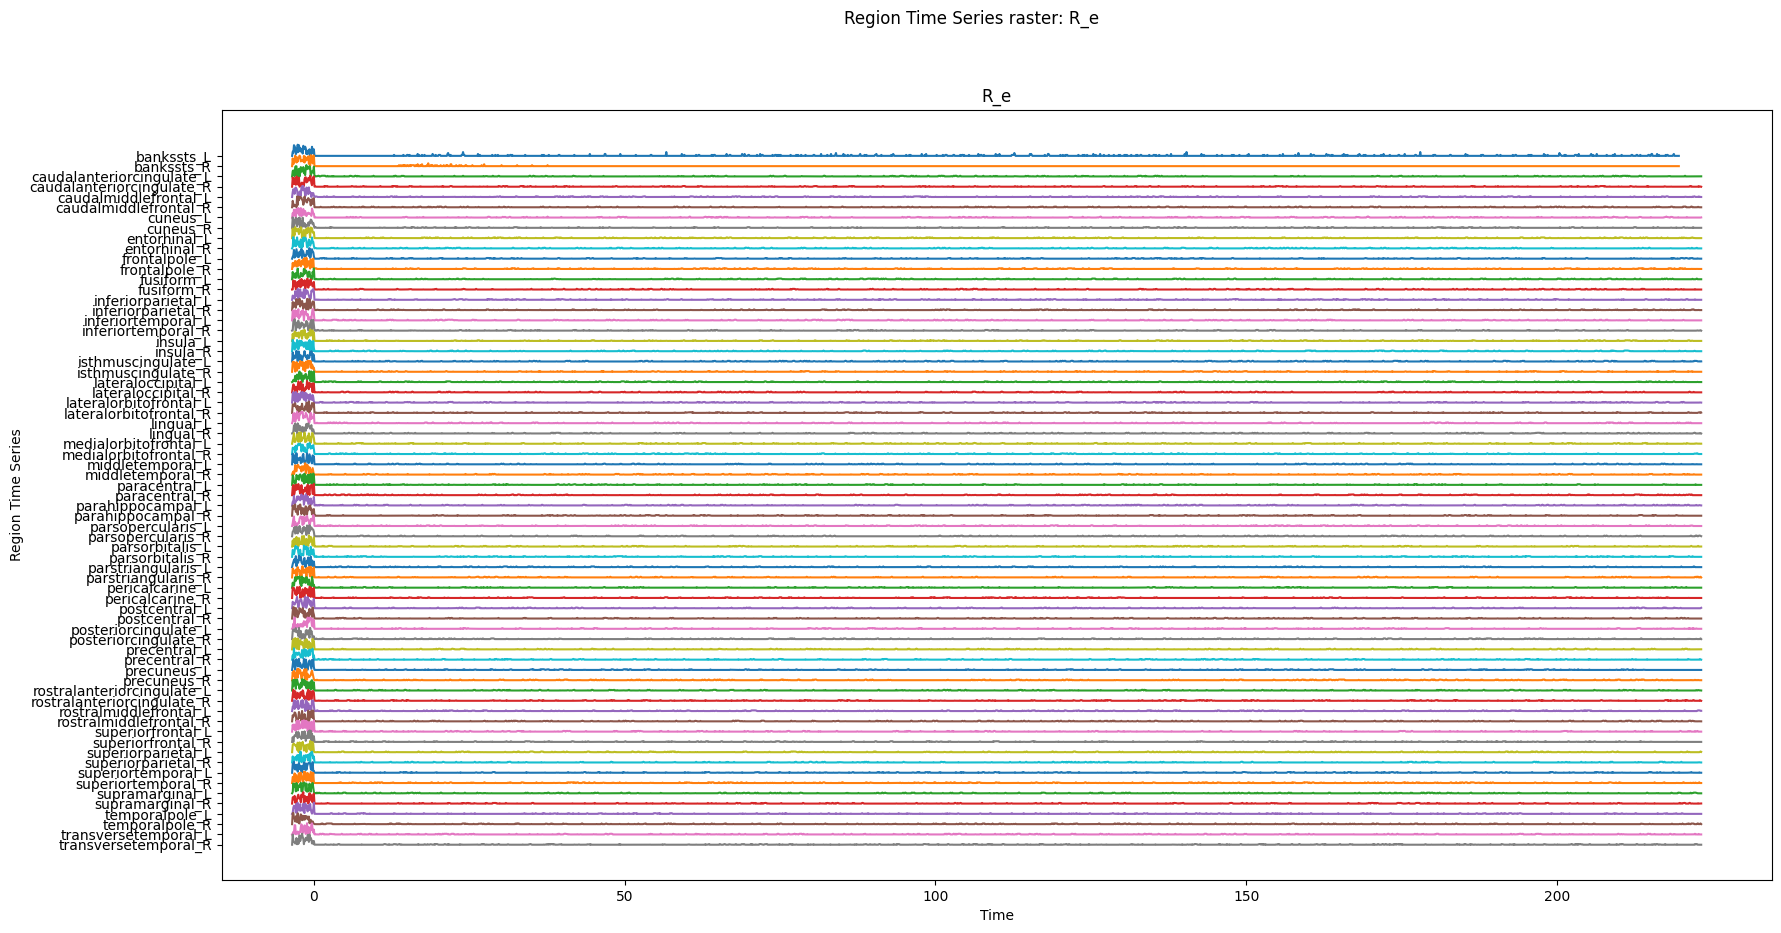

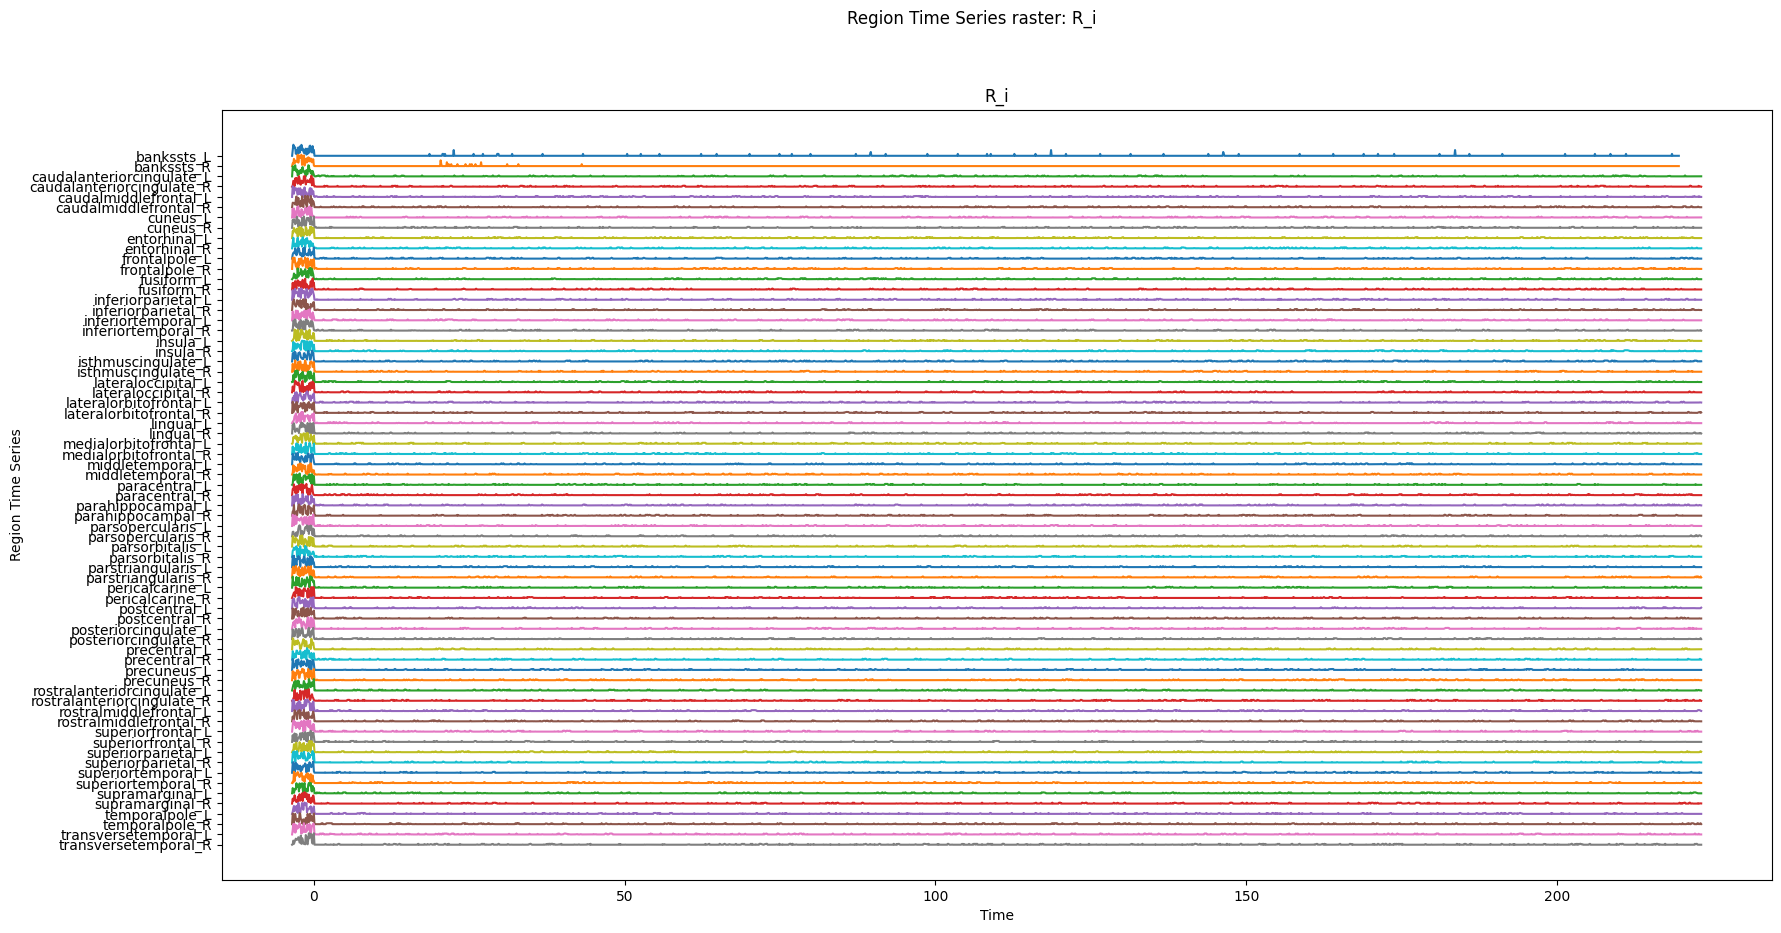

In [10]:
# Raster plot
if source_ts is not None and source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts.plot_raster(plotter_config=plotter.config, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
                          figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

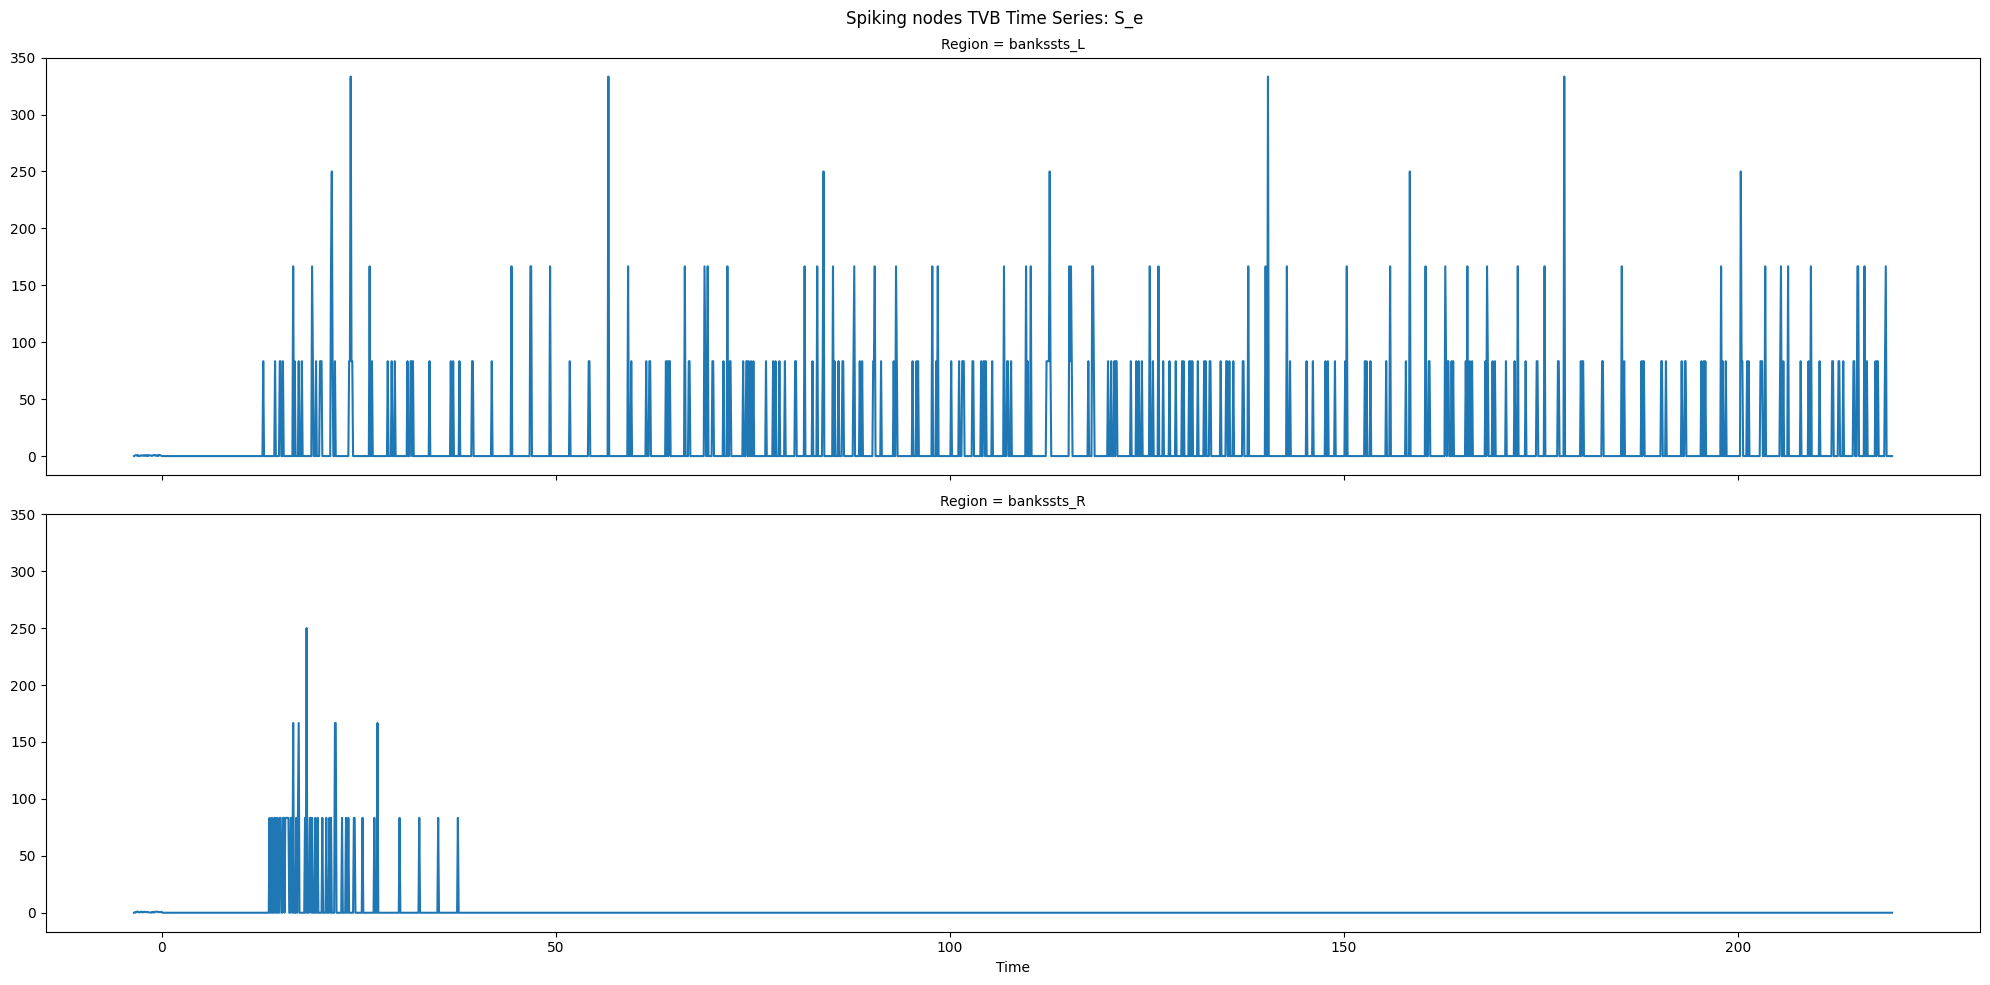

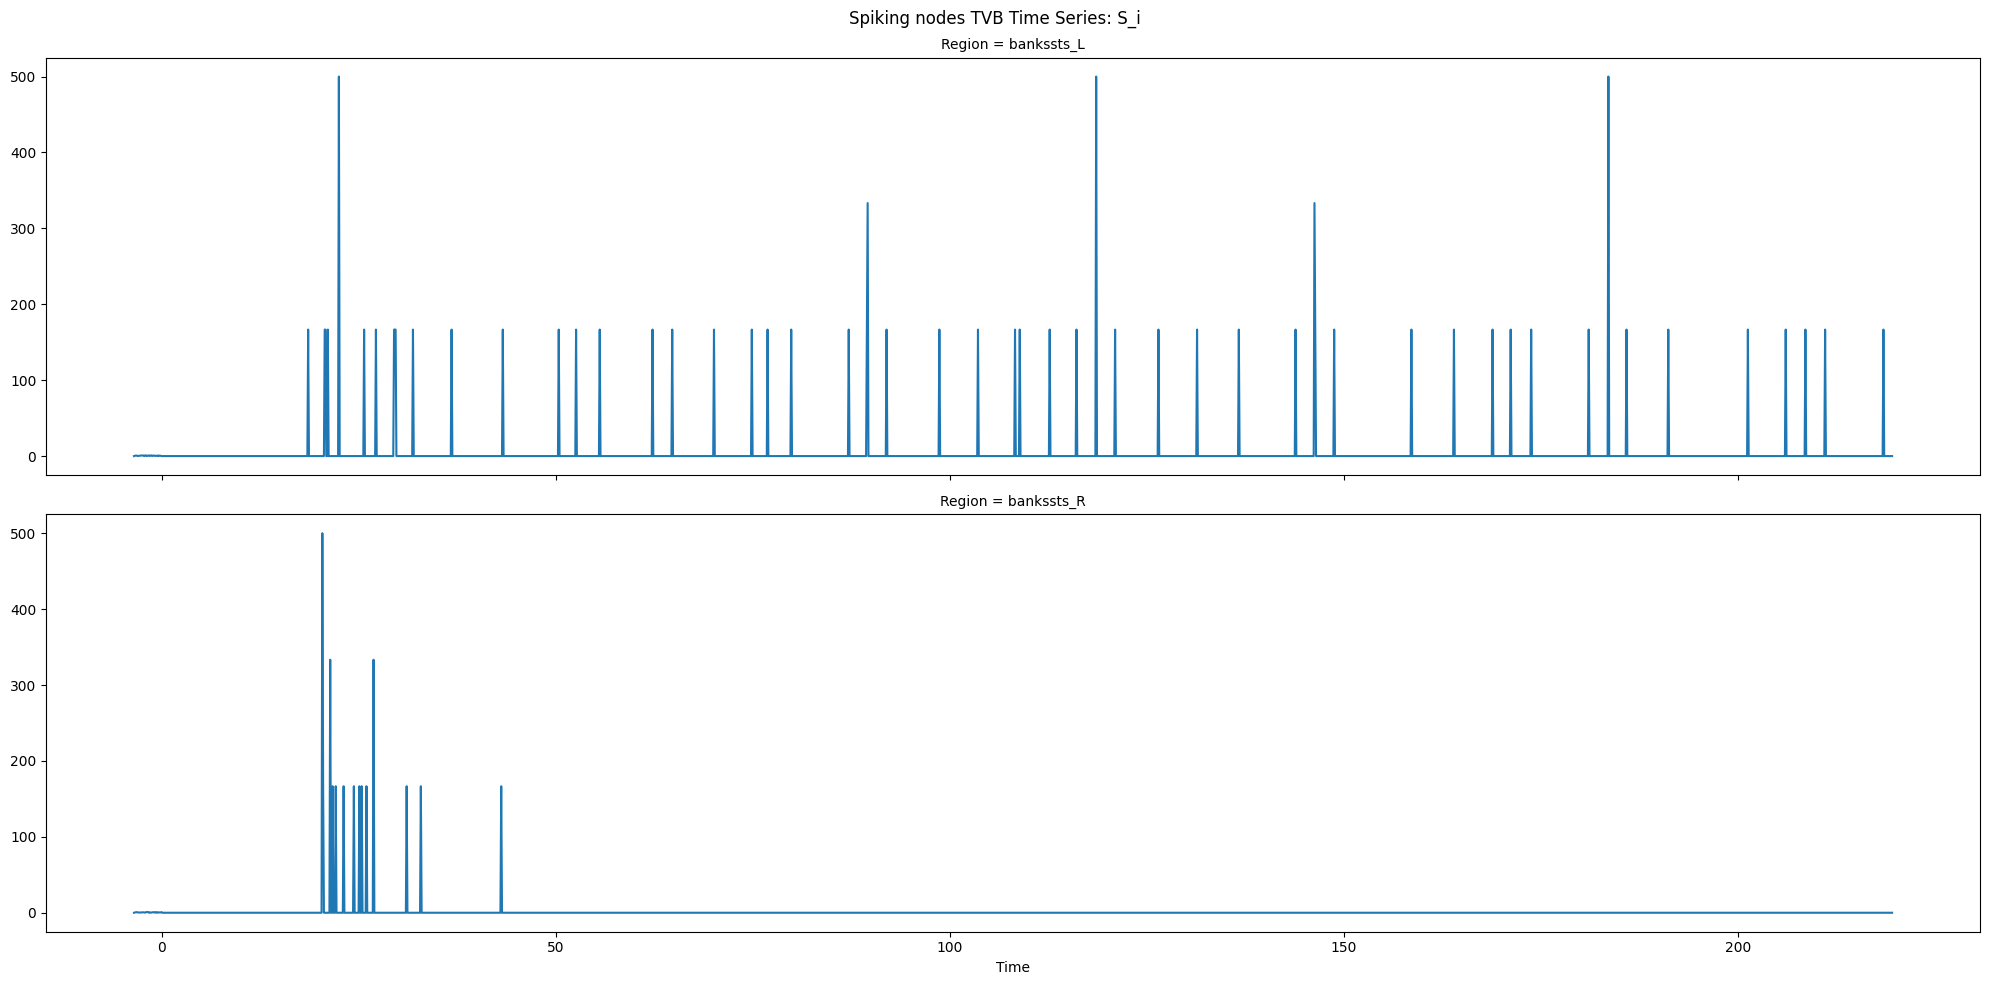

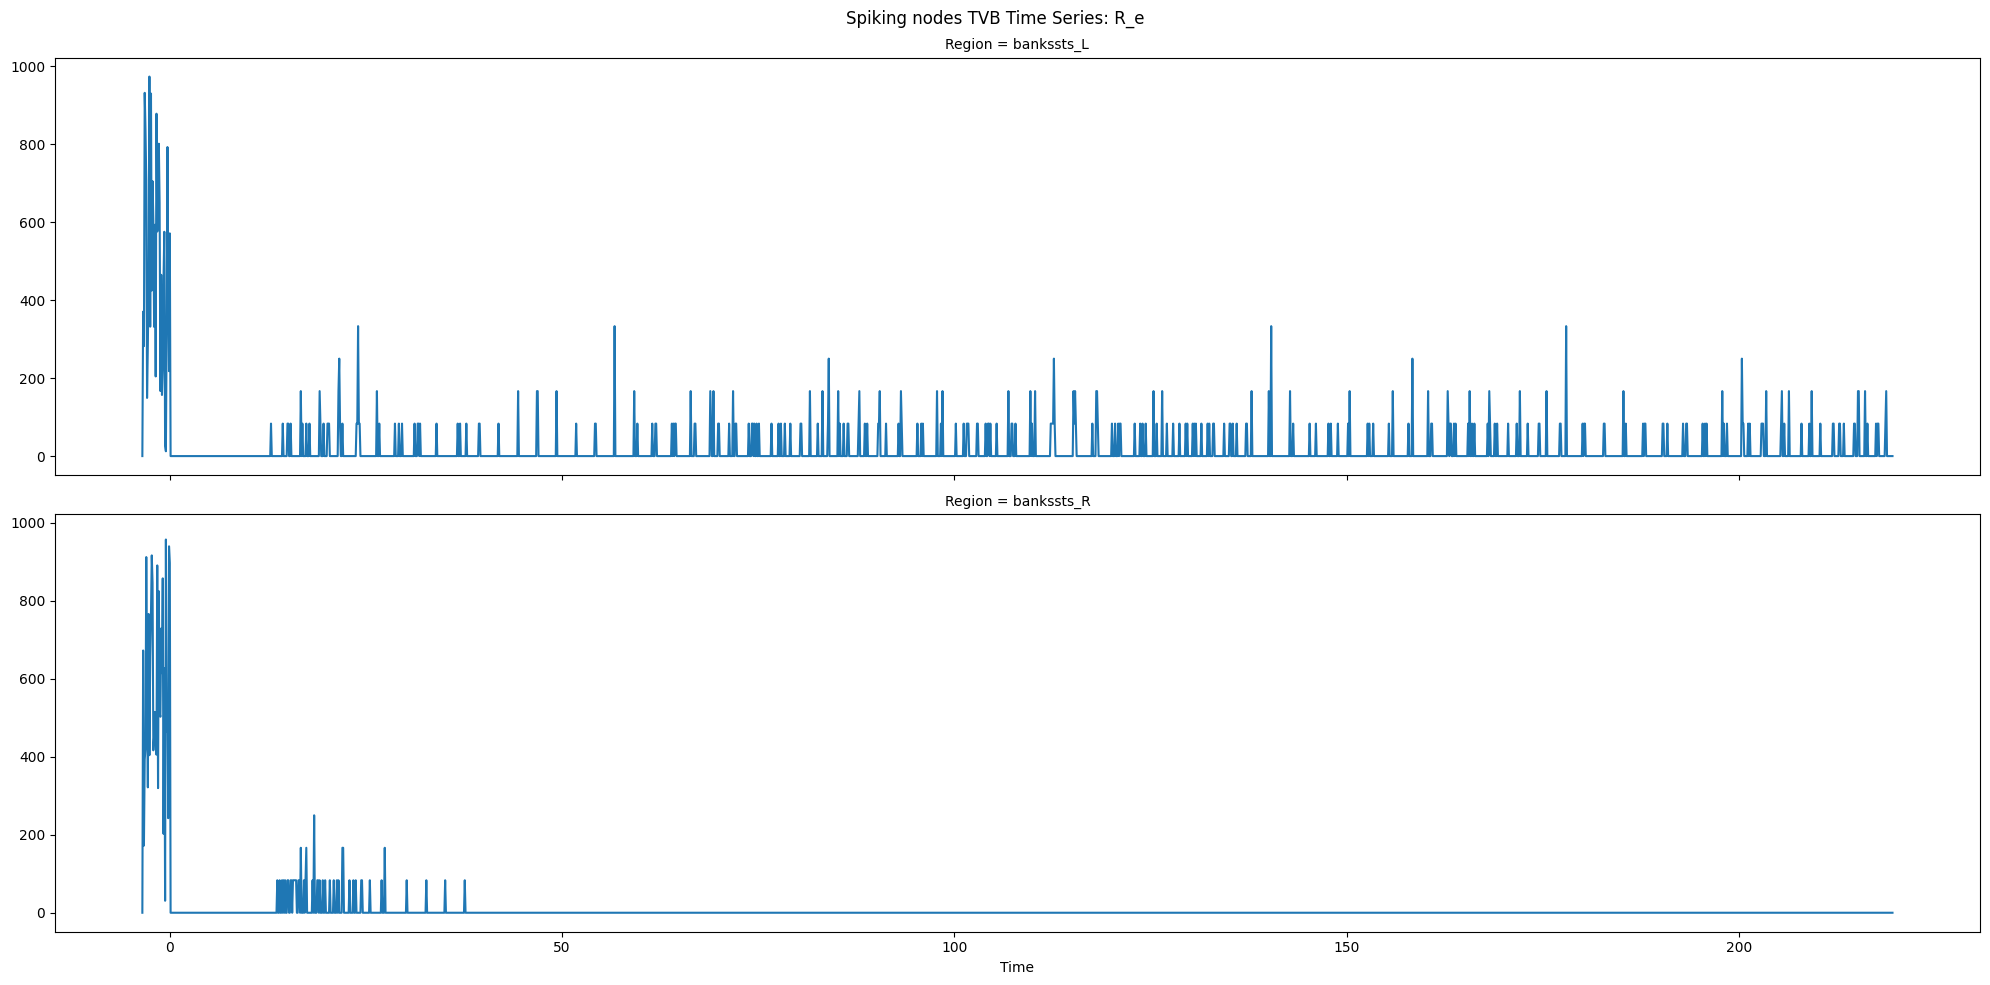

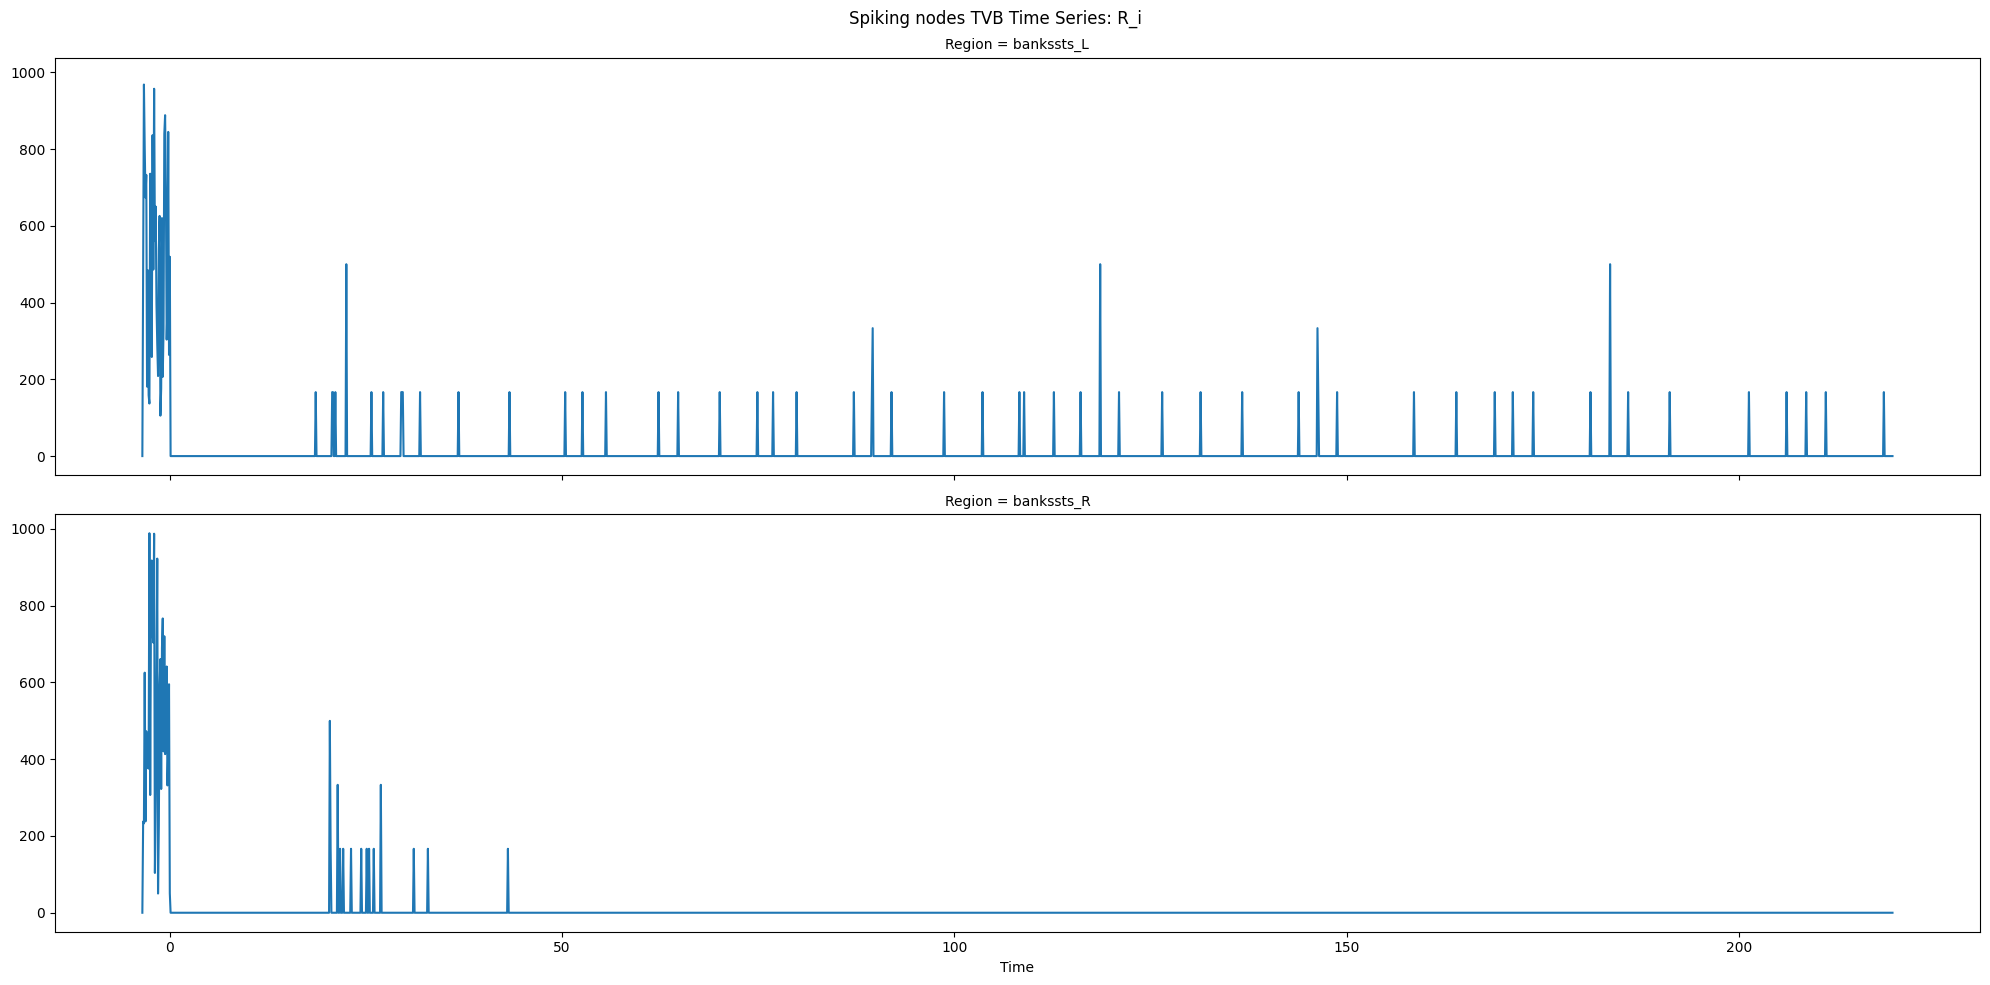

In [11]:
# Focus on the nodes modelled in NetPyNE: 
n_spiking_nodes = len(NETPYNE_NODES_INDS)
if source_ts is not None and n_spiking_nodes:
    source_ts_nest = source_ts[:, :, NETPYNE_NODES_INDS]
    source_ts_nest.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_nest.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

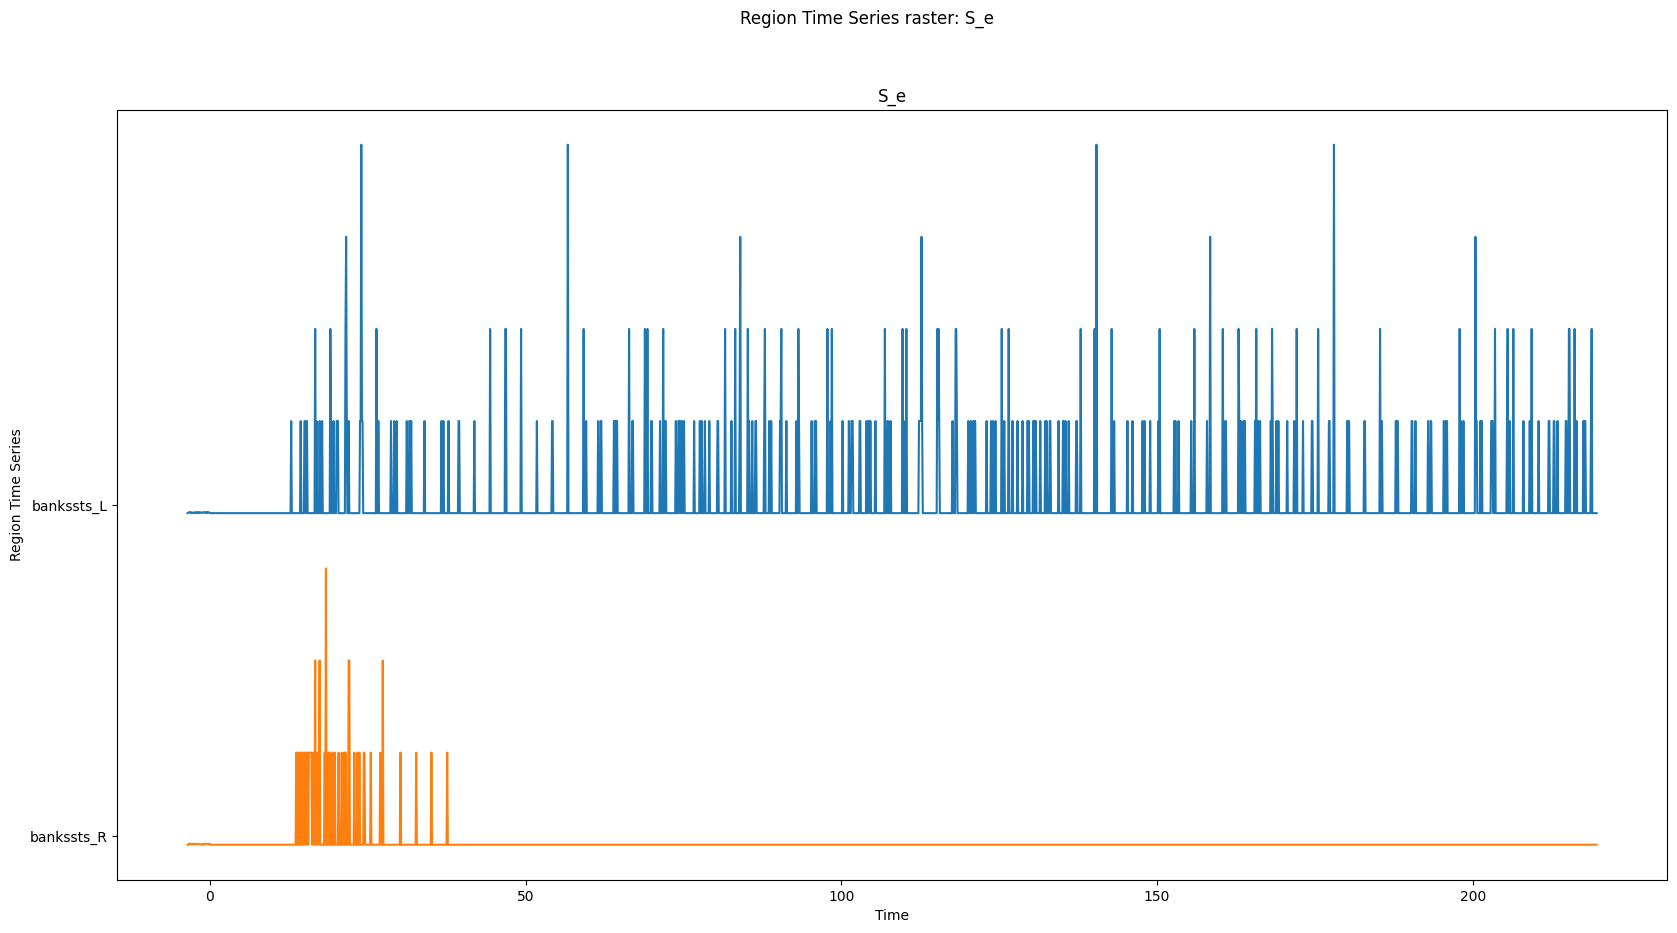

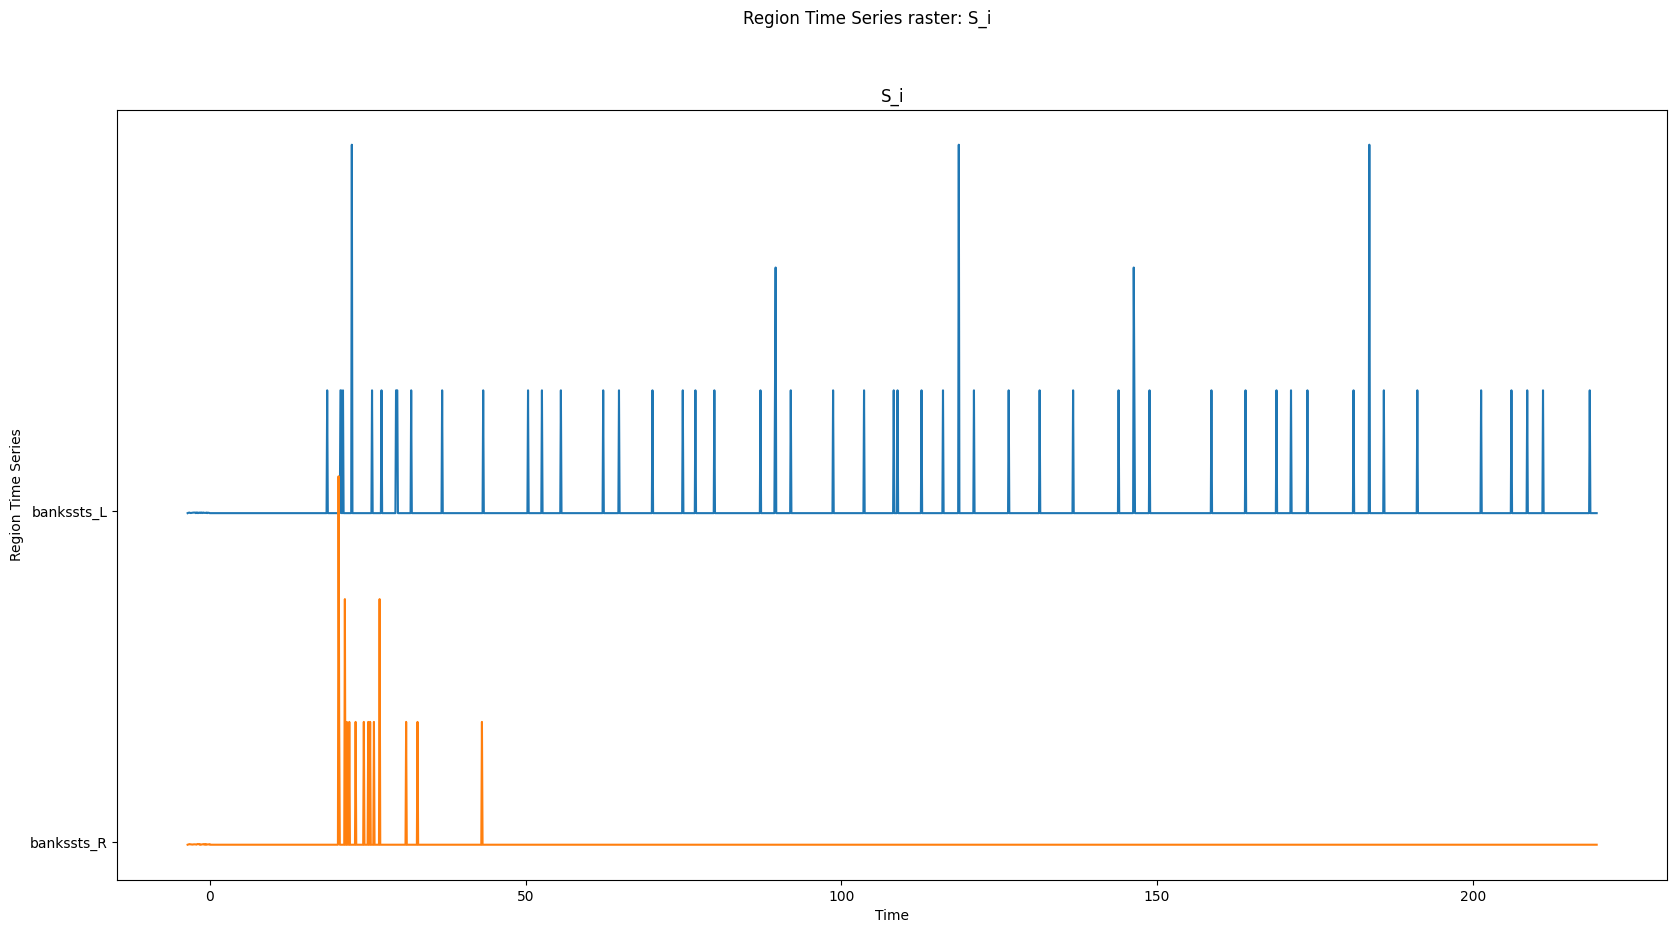

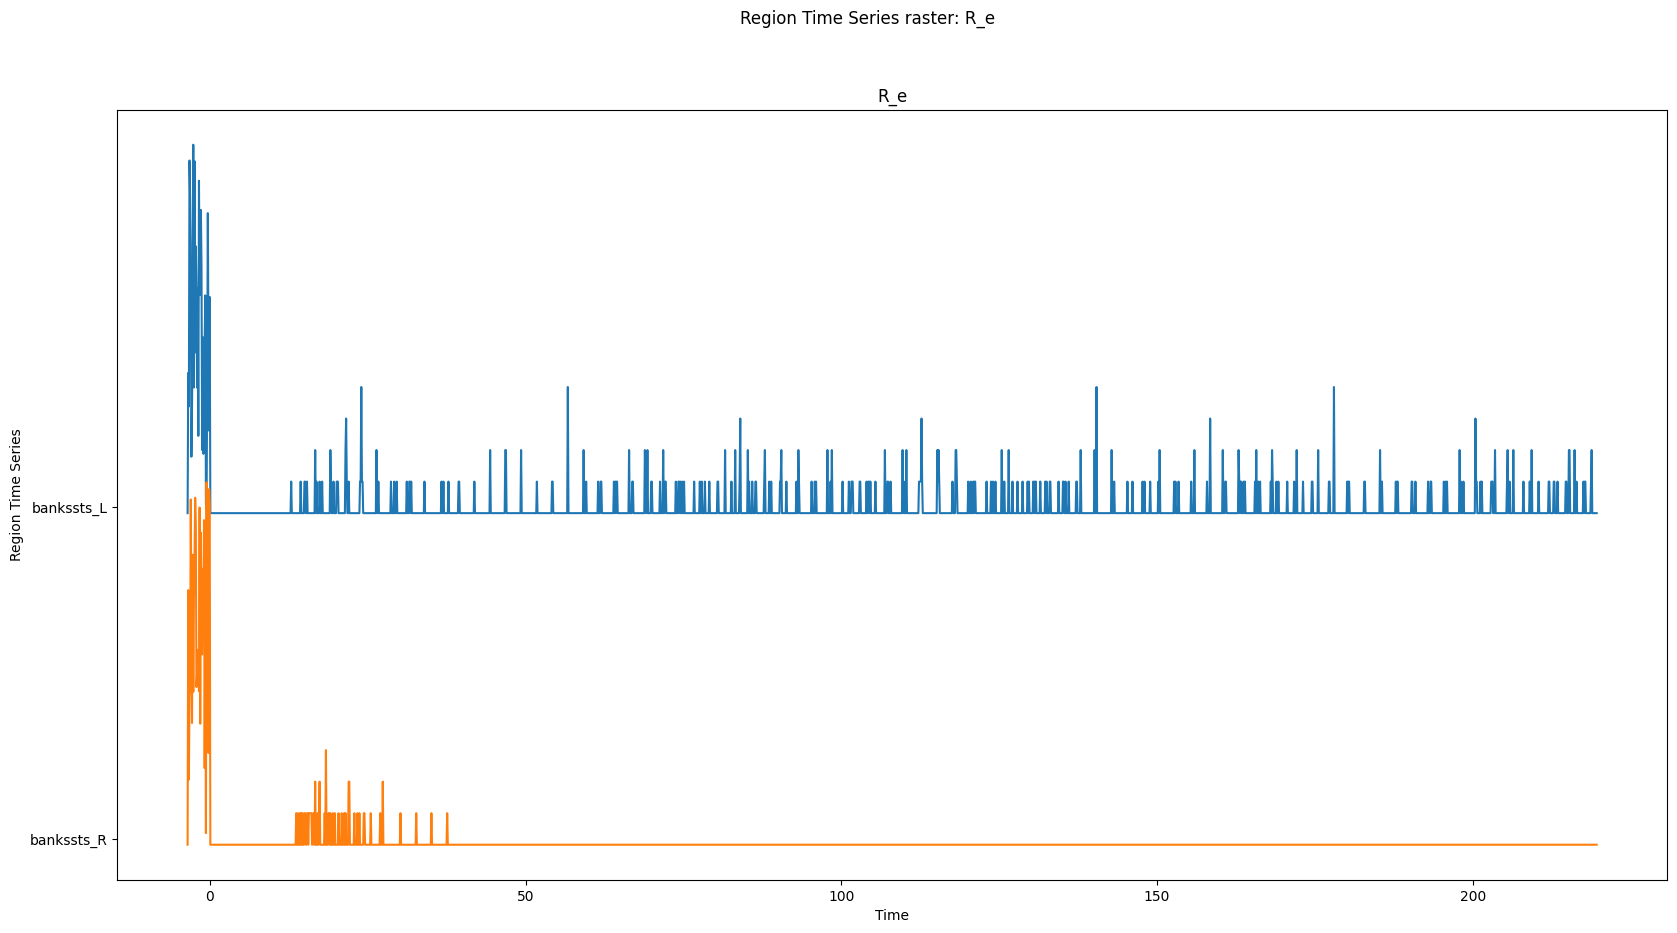

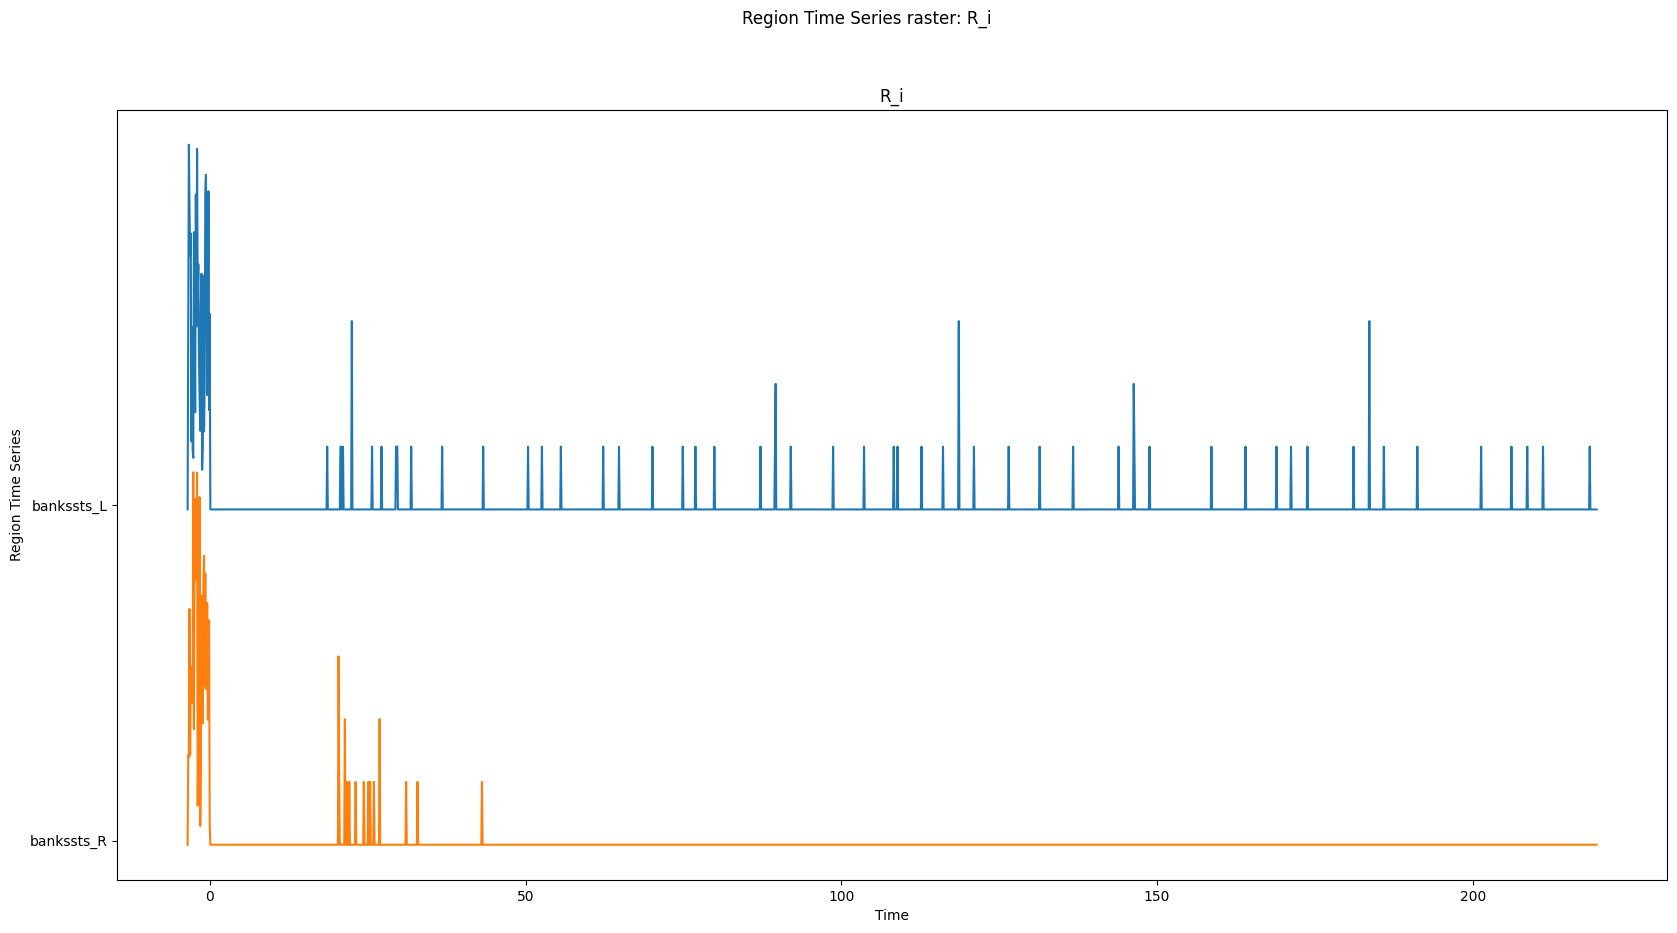

In [12]:
# Focus on the nodes modelled in NetPyNE: raster plot
if source_ts is not None and n_spiking_nodes: # and source_ts_nest.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_nest.plot_raster(plotter_config=plotter.config, 
                               per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS,
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

## Interactive time series plot

In [13]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

## Spiking Network plots

In [14]:
spikeNet_analyzer = None
if netpyne_network is not None:
    from tvb_multiscale.core.data_analysis.spiking_network_analyser import SpikingNetworkAnalyser
    # Create a SpikingNetworkAnalyzer:
    spikeNet_analyzer = \
        SpikingNetworkAnalyser(spikeNet=netpyne_network,
                               start_time=0.0, end_time=simulation_length, 
                               transient=transient, time_series_output_type="TVB", 
                               return_data=True, force_homogeneous_results=True, 
                               period=simulator.monitors[0].period, connectivity=simulator.connectivity
                              )

### Plot spikes' raster and mean spike rates and correlations

In [15]:
spikes_res = None
if spikeNet_analyzer is not None:
    # Spikes rates and correlations per Population and Region
    spikes_res = \
        spikeNet_analyzer.\
            compute_spikeNet_spikes_rates_and_correlations(
                populations_devices=None, regions=None,
                rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
                corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
                data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
                return_devices=False
            );

2022-11-04 07:29:49,208 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model  for  created!
2022-11-04 07:29:49,208 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model  for  created!


/home/docker/env/neurosci/lib/python3.9/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 2, Region: 2)>
array([[13.48234422,  0.53929377],
       [ 4.89512805,  0.82968272]])
Coordinates:
  * Region      (Region) object 'bankssts_L' 'bankssts_R'
  * Population  (Population) object 'E' 'I'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 2,
                                                          Population_j: 2,
                                                          Region_i: 2,
                                                          Region_j: 2)>
array([[[[ 1.        ,  0.1414666 ],
         [ 0.1414666 ,  1.        ]],

        [[ 0.00895227, -0.02507193],
         [-0.05566665,  0.09291593]]],


       [[[ 0.00895227, -0.05566665],
         [-0.02507193,  0.09291593]],

        [[ 1.        , -0.02807937],
         [-0.02807937,  1.        ]]]])
Coordinates:
  * Population_i  (Population_i) object 'E' 'I'
  * Region_i      (Region_i) object 'bankssts_L' 'bankssts_R'
  * Populat

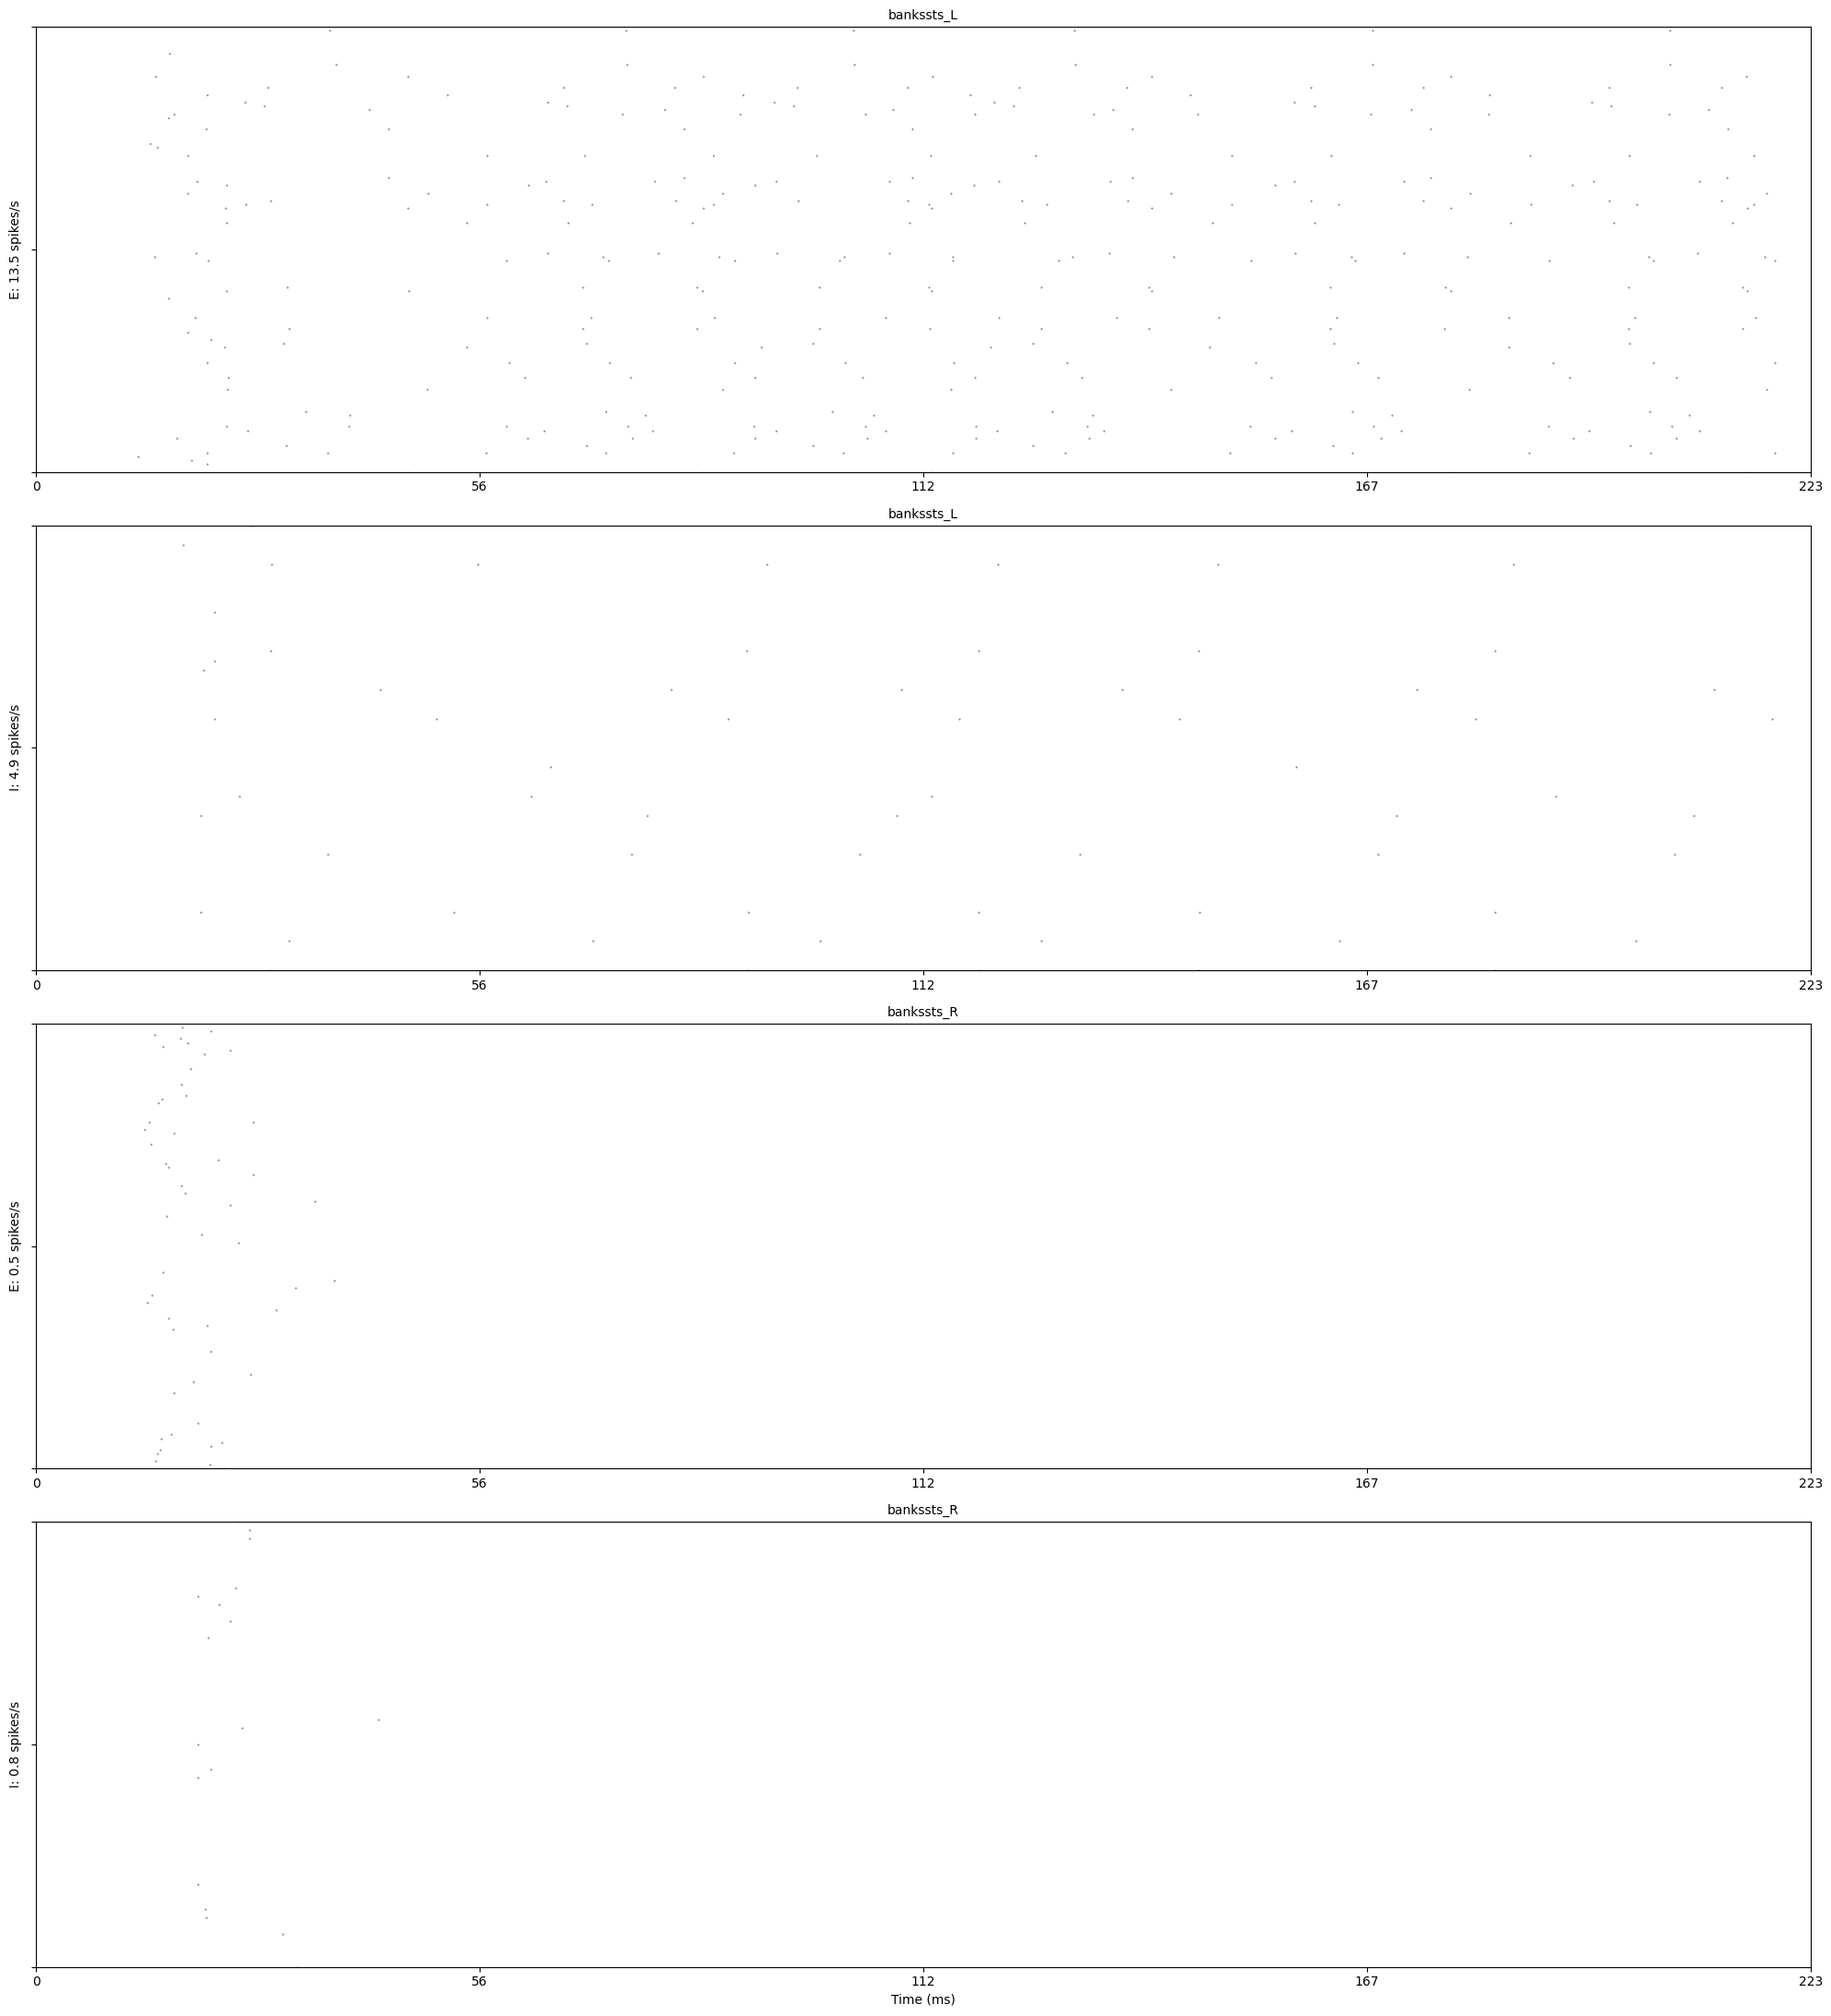

<Figure size 640x480 with 0 Axes>

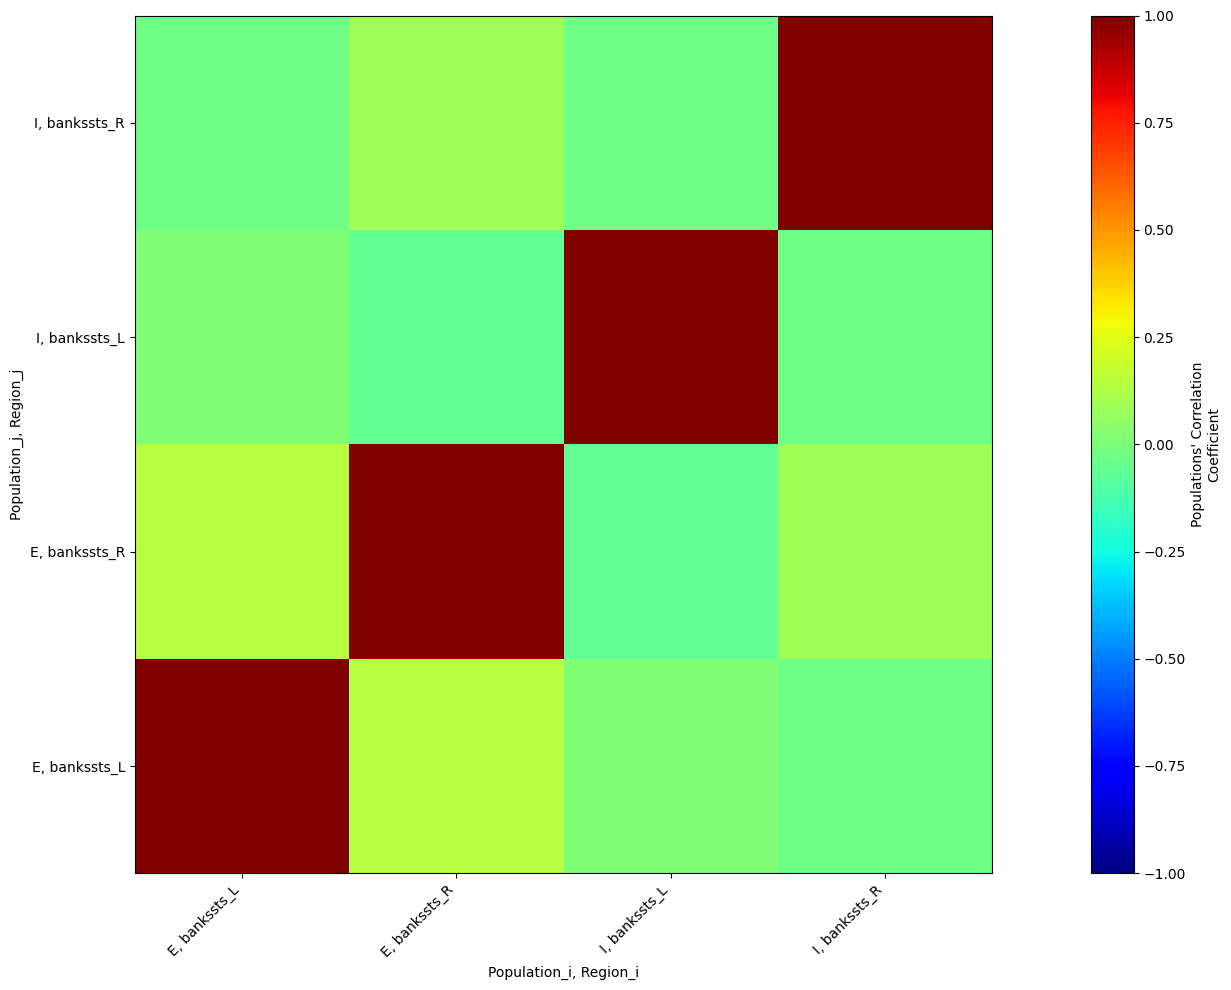

In [16]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], mean_results=spikes_res["mean_rate"], # time_series=spikes_res["mean_rate_time_series"], 
                                  figsize=(20, 22),  
                                  stimulus=None,
                                  stimulus_linewidth=5.0,
                                  spikes_markersize=0.5, spikes_alpha=0.5,
                                  n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                                  time_axis_min=0.0, time_axis_max=simulation_length)
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)